# LANL Authentication Data: End-to-End Graph + Anomaly Detection Pipeline

This notebook applies a structured 9-step workflow to the **LANL authentication dataset**  (using `auth.txt` and `redteam.txt`) to explore red team behaviour, build graphs, embed them with SVD, and evaluate anomaly detection methods.

---

## Workflow Overview

1. **Red Team Extraction**  
   - Load `redteam.txt` and derive activity timelines, users, and computers.

2. **Auth Subsetting**  
   - Stream `auth.txt`, filter to selected days (early/peak/late),  
     optionally restrict to events involving red team entities, and save subsets.

3. **Auth Period Analysis**  
   - Inspect basic statistics per period: success rates, failed logins,  
     red vs non-red involvement.

4. **Computer Behaviour Features**  
   - Engineer per-computer summaries: event counts, unique partners,  
     success rates, entropy, red vs normal distributions.

5. **Graph Construction & Structure**  
   - Build directed computer-to-computer graphs (“who talked to whom”),  
     analyse degree statistics, clustering, density, and log–log distributions.

6. **SVD Embedding**  
   - Symmetrise adjacency matrices, compute sparse SVD embeddings,  
     produce scree plots and embeddings for downstream analysis.

7. **Cluster Number Selection**  
   - Use KMeans/GMM with silhouette, AIC, and BIC to choose candidate  
     numbers of clusters (`k`).

8. **Clustering & Entropy Analysis**  
   - Explore different embedding dimensions (`d`) and cluster counts (`k`),  
     compare Binary vs Mixed Membership settings, inspect entropy distributions,  
     and overlay red team nodes.

9. **Anomaly Detection Evaluation**  
   - Apply KMeans distance, GMM negative log-likelihood, and GMM entropy  
     as anomaly scores.  
   - Report Precision/Recall@K, ROC AUC, and entropy summaries.  
   - Identify best-performing methods per period and configuration.

---

This roadmap ensures each stage — from raw LANL logs to anomaly metrics —  
is explicit, reproducible, and connected to the next.

---
---

### <u>LANL ARCS Dataset — Comprehensive, Multi-Source Cyber-Security Events</u>

**Source:**  
Los Alamos National Laboratory (LANL), collected over **58 consecutive days**.  
**Size:** ~12 GB compressed (~1.65 billion events).  
**Entities:** ~12.4k users, ~17.7k computers, ~63k processes.  
**License:** CC0 (public domain).

---

#### Data Sources

1. **Authentication (`auth.txt.gz`)**
   - Windows logon events:  
     ```
     time, source user@domain, destination user@domain,
     source computer, destination computer,
     authentication type, logon type, orientation, success/failure
     ```

2. **Process (`proc.txt.gz`)**
   - Start/stop events of processes:  
     ```
     time, user@domain, computer, process name, start/end
     ```

3. **Flows (`flows.txt.gz`)**
   - Netflow-style router captures:  
     ```
     time, duration, source computer, source port,
     destination computer, destination port, protocol,
     packet count, byte count
     ```

4. **DNS (`dns.txt.gz`)**
   - Internal DNS resolution lookups:  
     ```
     time, source computer, resolved computer
     ```

5. **Red Team Ground Truth (`redteam.txt.gz`)**
   - Known compromise events:  
     ```
     time, user@domain, source computer, destination computer
     ```

---

#### Key Properties
- **De-identified:** Users (U1, U2, …), Computers (C1, …), Processes (P1, …).  
- **Ground truth available:** red team activities.  
- **Unified identifiers:** Consistent across files (e.g. `U1` = same user everywhere).  
- **Epoch time:** Starts at 1 with second resolution.  

---

#### Citation
- **Paper:**  
  > A. D. Kent, "Cybersecurity Data Sources for Dynamic Network Research,"  
  > *Dynamic Networks in Cybersecurity*, Imperial College Press, 2015.  

- **Dataset DOI:**  
  > A. D. Kent, *Comprehensive, Multi-Source Cyber-Security Events*,  
  > Los Alamos National Laboratory, doi:[10.17021/1179829](http://dx.doi.org/10.17021/1179829), 2015.  

---

#### Usage
This dataset is widely used for:
- **Graph/network modelling** (auth events -> dynamic graphs).  
- **Anomaly detection** (red team ground truth).  
- **Temporal analysis** (58-day continuous stream).  
- **Multi-modal fusion** (auth + proc + flows + dns).

---

### <u>Data Assumptions</u>

The following code assumes that the **LANL ARCS dataset** (*Comprehensive, Multi-Source Cyber-Security Events*) has been obtained from the official LANL distribution site. Access requires submitting a request form to Los Alamos National Laboratory.

[LANL ARCS dataset page](https://csr.lanl.gov/data/cyber1/)

For this analysis, we specifically rely on:

- **`auth.txt.gz`** — Windows authentication events  
- **`redteam.txt.gz`** — Ground-truth red team compromise events  

Both files are expected to be available locally after extraction from the dataset archive.

---

In [1]:
# === Core Python & I/O Utilities ===
import os
import re
import random
import subprocess
from collections import Counter
from typing import Dict, List, Tuple, Optional
import time
from __future__ import annotations

# === Progress Bars ===
from tqdm import tqdm

# === Data Handling ===
import numpy as np
import pandas as pd
import scipy.sparse as sp

# === Visualisation ===
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines

# === Graph Processing ===
import networkx as nx

# === Dimensionality Reduction & Normalisation ===
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from scipy.sparse.linalg import svds
from scipy.spatial import procrustes

# === Clustering Algorithms ===
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# === Evaluation Metrics ===
from sklearn.metrics import (
    auc as sklearn_auc,
    pairwise_distances,
    pairwise_distances_argmin_min,
    precision_score,
    recall_score,
    roc_auc_score,
    silhouette_score,
    precision_recall_curve
)
from scipy.stats import (
    entropy,
    ks_1samp,
    ks_2samp,
    uniform
)

# === Probabilistic Modelling ===
import pymc as pm
import pytensor.tensor as pt

In [2]:
# Seed for reproducability
np.random.seed(42)
random.seed(42)

### <u>Step 1: Load and Inspect Red Team Events</u>

This step processes the **`redteam.txt`** file from the LANL ARCS dataset, which contains ground-truth red team activity.  
The code works with either the uncompressed `.txt` file or the compressed `.txt.gz` version (handled automatically by Pandas).

---

#### Operations performed

1. **Load file**
   - Assign column names: `time`, `user`, `src_computer`, `dst_computer`.  
   - Read into a DataFrame with appropriate types (`int64` for time, categorical strings for identifiers).  
   - `compression="infer"` ensures both `.txt` and `.txt.gz` are supported transparently.

2. **Feature engineering**
   - Derive `day` (integer days since epoch, 86,400 seconds).  
   - Derive `time_hour` (integer hours since epoch, 3,600 seconds).  

3. **Optimisation**
   - Convert identifiers (`user`, `src_computer`, `dst_computer`) to categorical to reduce memory footprint.  
   - Sort events chronologically.

4. **Descriptive statistics**
   - Display sample rows, data types, and total event count.  
   - Compute time span and active days.  
   - Count red team events per day.  
   - Report number of unique users and computers.  
   - Identify top users and most active source computers.

5. **Visualisation**
   - Bar chart of the top 10 red team source computers.  
   - Line plot of hourly red team event counts across the dataset.  
   - Consistent colour palette: blue `(0.0, 0.4, 0.8)` applied to all plots.

6. **Summary variables**
   - `redteam_days`: sorted list of active days with red team events.  
   - `redteam_span`: minimum and maximum event times (seconds since epoch).

---

These outputs provide a first overview of red team activity: temporal distribution, most active users, and machines most involved in compromise events.

---

First few rows:


,time,user,src_computer,dst_computer,day,time_hour
0,150885,U620@DOM1,C17693,C1003,1,41
1,151036,U748@DOM1,C17693,C305,1,41
2,151648,U748@DOM1,C17693,C728,1,42
3,151993,U6115@DOM1,C17693,C1173,1,42
4,153792,U636@DOM1,C17693,C294,1,42



Data types:
time               int64
user            category
src_computer    category
dst_computer    category
day                int64
time_hour          int64
dtype: object

Total red team events: 749
Time range: 150885 to 2557047 seconds since dataset epoch
Active days in dataset: [1, 2, 5, 6, 7, 8, 9, 12, 13, 14, 15, 20, 21, 22, 26, 27, 28, 29]

Red team activity count per day:
day
1      10
2      15
5      21
6       3
7       1
8     273
9      15
12    209
13     81
14     35
15     26
20      1
21      4
22      1
26     26
27      9
28      3
29     16
dtype: int64

Unique red team users: 104
Unique red team computers: 305

Top red team users by event count:
user
U66@DOM1      118
U3005@DOM1     36
U737@DOM1      32
U1653@DOM1     31
U293@DOM1      31
U748@DOM1      26
U1723@DOM1     19
U8946@DOM1     19
U3635@DOM1     18
U9947@DOM1     15
Name: count, dtype: int64

Top red team source computers by event count:
src_computer
C17693    701
C22409     26
C19932     19
C18025  

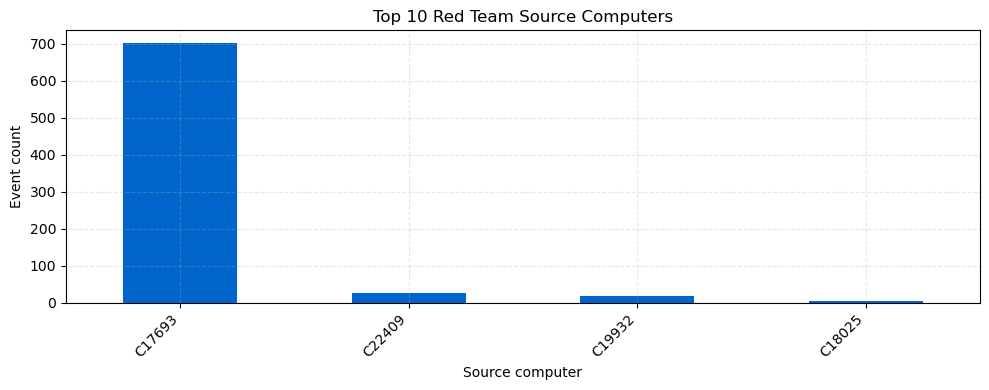

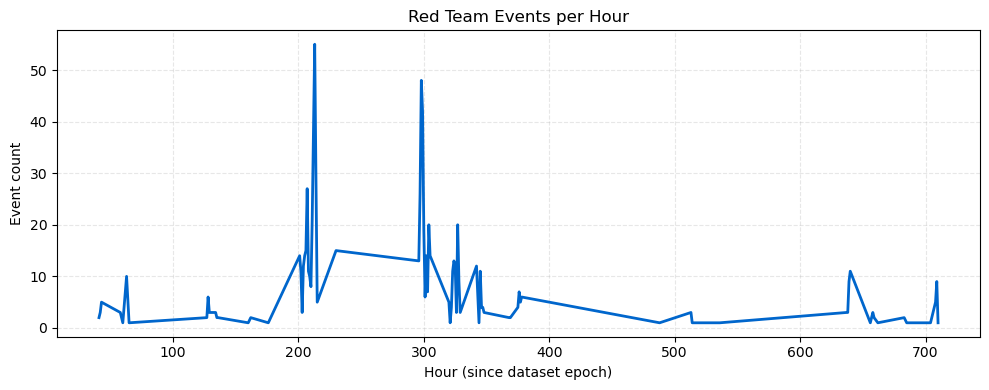

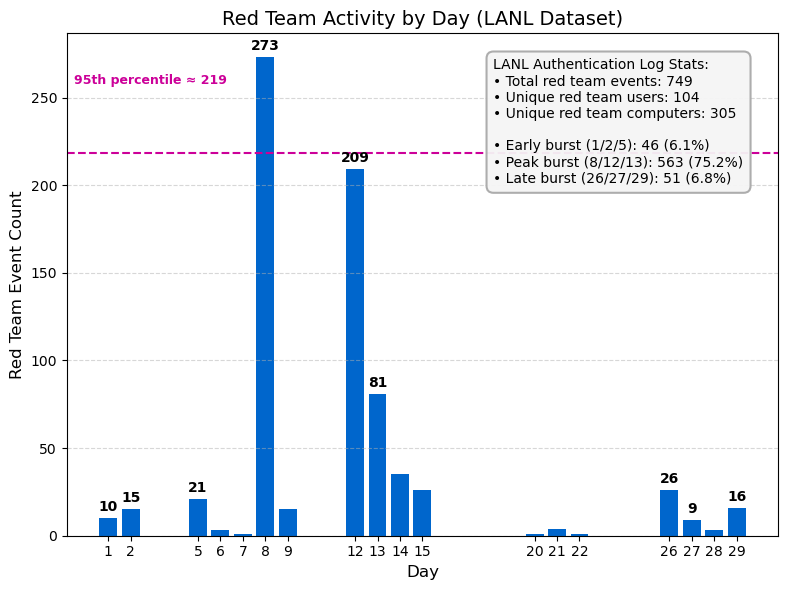


Using consistent blue colour: RGB(0, 102, 204)


In [3]:
# Step 1: Load redteam.txt and inspect
# Define column names as per dataset documentation
red_cols = ["time", "user", "src_computer", "dst_computer"]

# Load (handles .txt or .gz)
df_red = pd.read_csv(
    "redteam.txt",
    names=red_cols,
    header=None,
    compression="infer",
    dtype={"time": "int64", "user": "string", "src_computer": "string", "dst_computer": "string"},
)

# Derive day/hour (LANL time is seconds since dataset epoch starting at 1)
df_red["day"] = df_red["time"] // 86400  # seconds per day
df_red["time_hour"] = df_red["time"] // 3600  # seconds per hour

# Memory optimisation for IDs
for col in ["user", "src_computer", "dst_computer"]:
    df_red[col] = df_red[col].astype("category")

# Sort chronologically
df_red = df_red.sort_values("time", kind="stable").reset_index(drop=True)

# Display basic info and summary statistics
print("First few rows:")
display(df_red.head())
print("\nData types:")
print(df_red.dtypes)
print(f"\nTotal red team events: {len(df_red)}")
print(f"Time range: {df_red['time'].min()} to {df_red['time'].max()} seconds since dataset epoch")
print(f"Active days in dataset: {sorted(df_red['day'].unique().tolist())}")
print("\nRed team activity count per day:")
print(df_red.groupby("day").size().sort_index())

# Unique red team users and computers
red_users = df_red["user"].cat.categories if hasattr(df_red["user"], "cat") else df_red["user"].unique()
red_computers = pd.unique(df_red[["src_computer", "dst_computer"]].values.ravel())
print(f"\nUnique red team users: {df_red['user'].nunique()}")
print(f"Unique red team computers: {len(red_computers)}")

# Top users
top_users = df_red["user"].value_counts().head(10)
print("\nTop red team users by event count:")
print(top_users)

# Top sources
src_counts = df_red["src_computer"].value_counts()
print("\nTop red team source computers by event count:")
print(src_counts.head(10))

# Consistent blue colour
consistent_blue = (0.0, 0.4, 0.8)

# Plot top 10 source computers with consistent colour
plt.figure(figsize=(10, 4))
src_counts.head(10).plot(kind="bar", title="Top 10 Red Team Source Computers", 
                        color=consistent_blue)
plt.ylabel("Event count")
plt.xlabel("Source computer")
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot hourly count of red team events over time with consistent colour
plt.figure(figsize=(10, 4))
df_red.groupby("time_hour").size().plot(title="Red Team Events per Hour", 
                                       color=consistent_blue, linewidth=2)
plt.xlabel("Hour (since dataset epoch)")
plt.ylabel("Event count")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Build daily counts directly from df_red
daily_counts = (
    df_red.groupby("day")
          .size()
          .reset_index(name="Event Count")
          .rename(columns={"day": "Day"})
          .sort_values("Day")
)

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(daily_counts["Day"], daily_counts["Event Count"], color=(0.0, 0.4, 0.8))

# Days to annotate
annot_days = {1, 2, 5, 8, 12, 13, 26, 27, 29}

for bar, day in zip(bars, daily_counts["Day"]):
    height = bar.get_height()
    if day in annot_days:  # only mark these days
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points",
                    ha='center', fontsize=10, fontweight='bold')

# Define groups of days
groups = {
    "Early burst (1/2/5)": {1, 2, 5},
    "Peak burst (8/12/13)": {8, 12, 13},
    "Late burst (26/27/29)": {26, 27, 29},
}

total_events = len(df_red)

# Compute group percentages
group_lines = []
for label, days in groups.items():
    count = daily_counts.loc[daily_counts["Day"].isin(days), "Event Count"].sum()
    pct = 100 * count / total_events
    group_lines.append(f"• {label}: {count} ({pct:.1f}%)")

# Extend legend text
legend_text = (
    "LANL Authentication Log Stats:\n"
    f"• Total red team events: {total_events}\n"
    f"• Unique red team users: {df_red['user'].nunique()}\n"
    f"• Unique red team computers: "
    f"{pd.concat([df_red['src_computer'], df_red['dst_computer']]).nunique()}\n\n"
    + "\n".join(group_lines)  # add group stats
)

# Add custom legend-style box as a pseudo-legend
legend = ax.text(0.60, 0.95, legend_text, transform=ax.transAxes,
                 fontsize=10, va='top',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='whitesmoke',
                           edgecolor='darkgray', linewidth=1.5, alpha=0.95))

# 95%ile threshold
thr95 = np.percentile(daily_counts["Event Count"], 95)
highlight_color = (0.8, 0.0, 0.6)  # magenta, color-blind friendly

ax.axhline(thr95, linestyle='--', linewidth=1.5, color=highlight_color)
ax.text(0.01, 0.92, f"95th percentile ≈ {thr95:.0f}",
        transform=ax.transAxes, va='top', fontsize=9,
        color=highlight_color, fontweight='bold')

ax.set_title("Red Team Activity by Day (LANL Dataset)", fontsize=14)
ax.set_xlabel("Day", fontsize=12)
ax.set_ylabel("Red Team Event Count", fontsize=12)
ax.set_xticks(daily_counts["Day"])
ax.grid(axis='y', linestyle='--', alpha=0.5)

fig.tight_layout()
fig.savefig("redteam.pdf", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Store summary variables for later use
redteam_days = sorted(df_red["day"].unique().tolist())
redteam_span = (int(df_red["time"].min()), int(df_red["time"].max()))

print(f"\nUsing consistent blue colour: RGB{tuple(int(c * 255) for c in consistent_blue)}")

### <u>Step 2: Stream and Filter Authentication Events</u>

This step processes the **`auth.txt`** file from the LANL ARCS dataset, aligning it with red team activity derived from **`redteam.txt`**.  
The script is designed for efficiency, streaming line by line rather than loading the entire file into memory.

---

#### Operations performed

1. **Configuration**
   - Input files: `auth.txt` (authentication events) and `redteam.txt` (ground truth).  
   - Output directory: `lanl_output/`.  
   - Options:  
     - `COMPRESS`: save as `.csv.gz` if `True`, else `.csv`.  
     - `ONLY_REDS`: retain only events involving red team users or computers.  
     - `DROP_QUESTION_MARKS`: exclude any row containing the `"?"` placeholder.  
   - Time unit: 86,400 seconds per day.  
   - Analysis periods defined: `early`, `peak`, `late` (based on red team activity days).

2. **Red team entities**
   - Load `redteam.txt` and normalise identifiers (users and computers to upper case).  
   - Create sets of red team users and computers for filtering.

3. **Period handling**
   - Map selected days into the categories `early`, `peak`, and `late`.  
   - Establish a cutoff time to stop processing once the last day of interest is reached.

4. **Streaming authentication events**
   - Stream `auth.txt` line by line.  
   - Apply filters:
     - Exclude malformed rows or rows with `"?"`.  
     - Stop early once the cutoff day is passed.  
     - Retain only target days.  
     - If `ONLY_REDS=True`, retain only events involving red team users or computers.  
   - Track statistics with counters (total read, excluded by rule, kept).

5. **Data storage**
   - For each period (`early`, `peak`, `late`), build a DataFrame.  
   - Optimise types: `time` as `int64`, categorical for identifiers and event attributes.  
   - Save per-period CSVs with consistent naming:
     - Example: `auth_early_redonly.csv.gz`.

6. **Summary**
   - Print counts of total lines processed, reasons for exclusion, and numbers saved per period.  
   - Report elapsed time and processing throughput.

---

#### Outputs

- Compressed or uncompressed CSVs for each selected period containing authentication events linked to red team activity.  
- Detailed summary of filtering statistics, enabling verification of data reduction.

---

In [4]:
# -------- Settings --------
AUTH_PATH = "auth.txt"          # input
REDTEAM_PATH = "redteam.txt"    # input
OUT_DIR = "lanl_output"         # where to save
COMPRESS = True                 # .csv.gz if True, else .csv
ONLY_REDS = True                # True: keep only events involving red team users/computers
DROP_QUESTION_MARKS = True      # skip rows with any "?" token
DAY_SECONDS = 86_400

In [5]:
# --- Periods based on redteam.txt attack data ---
periods = {
    "early": [1, 2, 5],
    "peak":  [8, 12, 13],
    "late":  [26, 27, 29],
}

# -------- Helpers --------
def normalise_id(s: str) -> str:
    return (s or "").strip().upper()

auth_cols = [
    "time","src_user","dst_user",
    "src_computer","dst_computer",
    "auth_type","logon_type","auth_orientation","success"
]

# -------- Load red team entities --------
# redteam.txt columns: time, user, src_computer, dst_computer
df_red = pd.read_csv(
    REDTEAM_PATH,
    names=["time","user","src_computer","dst_computer"],
    dtype=str
)
for c in ["user","src_computer","dst_computer"]:
    df_red[c] = df_red[c].map(normalise_id)

red_users = frozenset(df_red["user"].dropna().tolist())
red_computers = frozenset(df_red["src_computer"].dropna().tolist()) | \
                frozenset(df_red["dst_computer"].dropna().tolist())

# -------- Build day lookup & cutoff --------
day_to_period = {}
all_days = []
for p, days in periods.items():
    for d in days:
        day_to_period[d] = p
        all_days.append(d)

if not all_days:
    raise ValueError("No days provided in 'periods'.")

max_time_cutoff = (max(all_days)+1) * DAY_SECONDS

# Buckets per period (list of dict rows)
buckets = {p: [] for p in periods.keys()}

# -------- Counters --------
counts = Counter(
    total=0,
    bad_cols=0,
    has_qmark=0,
    after_cutoff=0,
    not_target_day=0,
    not_red=0,
    kept=0,
)
counts["elapsed"] = None  # set later

# -------- Stream auth.txt once --------
start = time.time()
with open(AUTH_PATH, "r", encoding="utf-8", errors="ignore") as f:
    for line in tqdm(f, desc="Streaming auth.txt for early/peak/late"):
        counts['total'] += 1
        parts = line.rstrip("\n").split(",")
        if len(parts) != len(auth_cols):
            counts['bad_cols'] += 1
            continue
        if DROP_QUESTION_MARKS and ("?" in parts):
            counts['has_qmark'] += 1
            continue

        row = dict(zip(auth_cols, parts))
        try:
            t = int(row["time"])  # fast parse
        except ValueError:
            counts['bad_cols'] += 1
            continue

        # stop after last day-of-interest
        if t >= max_time_cutoff:
            counts['after_cutoff'] += 1
            break  # safe early stop

        # which day?
        day = t // DAY_SECONDS
        period = day_to_period.get(day)
        if period is None:
            counts['not_target_day'] += 1
            continue

        # normalise ids
        row["src_user"]      = normalise_id(row["src_user"]) 
        row["dst_user"]      = normalise_id(row["dst_user"]) 
        row["src_computer"]  = normalise_id(row["src_computer"]) 
        row["dst_computer"]  = normalise_id(row["dst_computer"]) 
        row["time"] = t

        if ONLY_REDS:
            # keep if ANY red user/computer involved
            if not (
                (row["src_user"] in red_users) or
                (row["dst_user"] in red_users) or
                (row["src_computer"] in red_computers) or
                (row["dst_computer"] in red_computers)
            ):
                counts['not_red'] += 1
                continue

        buckets[period].append(row)
        counts['kept'] += 1
counts["elapsed"] = time.time() - start

# -------- Build DataFrames, optimise dtypes, save --------
os.makedirs(OUT_DIR, exist_ok=True)

saved_counts = {}
for period, rows in buckets.items():
    if not rows:
        print(f"[{period}] No events captured.")
        saved_counts[period] = 0
        continue

    df = pd.DataFrame(rows, columns=auth_cols)
    # dtype optimisations
    df["time"] = df["time"].astype(np.int64)
    for c in ["src_user","dst_user","src_computer","dst_computer",
              "auth_type","logon_type","auth_orientation","success"]:
        df[c] = df[c].astype("category")

    fname = f"auth_{period}_redonly.csv" if ONLY_REDS else f"auth_{period}_all.csv"
    path = os.path.join(OUT_DIR, fname + (".gz" if COMPRESS else ""))
    df.to_csv(path, index=False)
    saved_counts[period] = len(df)
    print(f"[{period}] Saved {len(df):,} rows -> {path}")

# -------- Summary --------
print("\nSummary (lines):")
print(f"  total read           : {counts['total']:,}")
print(f"  bad column count     : {counts['bad_cols']:,}")
print(f"  had '?' token        : {counts['has_qmark']:,}")
print(f"  not target day       : {counts['not_target_day']:,}")
print(f"  filtered by ONLY_REDS: {counts['not_red']:,}")
print(f"  after cutoff         : {counts['after_cutoff']:,}")
print(f"  kept (all periods)   : {counts['kept']:,}")
for p, n in saved_counts.items():
    print(f"    kept in {p:<5}      : {n:,}")

if counts['elapsed'] is not None:
    rate = counts['total'] / counts['elapsed'] if counts['elapsed'] > 0 else 0
    print(f"\nElapsed time          : {counts['elapsed']:.2f} sec")
    print(f"Throughput            : {rate:,.0f} lines/sec")

print("Done.")

Streaming auth.txt for early/peak/late: 508854104it [11:56, 709779.18it/s]


[early] Saved 17,226,216 rows -> lanl_output/auth_early_redonly.csv.gz
[peak] Saved 19,967,243 rows -> lanl_output/auth_peak_redonly.csv.gz
[late] Saved 18,470,865 rows -> lanl_output/auth_late_redonly.csv.gz

Summary (lines):
  total read           : 508,854,105
  bad column count     : 0
  had '?' token        : 293,146,475
  not target day       : 144,293,546
  filtered by ONLY_REDS: 15,749,759
  after cutoff         : 1
  kept (all periods)   : 55,664,324
    kept in early      : 17,226,216
    kept in peak       : 19,967,243
    kept in late       : 18,470,865

Elapsed time          : 716.95 sec
Throughput            : 709,752 lines/sec
Done.


### <u>Step 3: Authentication Analysis by Period (EDA)</u>

This stage analyses the **authentication logs (`auth.txt`)** filtered in the previous step into three periods (early, peak, late).  
If `ONLY_REDS=True`, the inputs contain only events involving red team users or red team computers.

---

#### Operations

1. **Load filtered authentication datasets**  
   - Reads per-period CSVs from the output directory:  
     `auth_early_redonly.csv.gz`, `auth_peak_redonly.csv.gz`, `auth_late_redonly.csv.gz` (present files only).  
   - Prints the number of events loaded per period.

2. **Per-period analysis (`analyse_auth_period`)**  
   For each period:
   - **Volume and rates**  
     - Total events kept after filtering.  
     - Events per day (`time // 86,400`).  
     - Success rate via normalised value counts of the `success` field.  
   - **Resource footprint and cardinalities**  
     - DataFrame memory usage (deep).  
     - Counts of unique users and unique computers, aggregated across source and destination fields.  
   - **Red team attribution split**  
     - Events where a red team user appears (`src_user` or `dst_user`).  
     - Events on red team computers with non‑red users.  
   - **Failed authentication analysis**  
     - Total failed events and day-wise breakdown.  
     - Top users and top source computers associated with failures.  
     - Computer account failures (`src_user` contains `"$"`), with proportion of all failures.  
     - Intersection of failing computers with the red team computer set.  
     - Feature engineering for failures:  
       - `hour` within day, and boolean `is_computer_account`.  
       - Hourly distribution of failures and distribution by `auth_type`.  
     - High-value indicators: business hours (08:00–17:00) versus off-hours failure proportions, and NTLM failure concentration.

3. **Comparative summary across periods**  
   - Builds a summary table with, per period:  
     - Total events.  
     - Success rate (percentage).  
     - Failed authentication count.  
     - Unique users and unique computers (source plus destination).  
   - Displays the table for quick comparison.

---

#### Outputs

- Console summaries per period covering volumes, rates, red team attribution, and failure characteristics.  
- A comparative summary table across early, peak, and late periods to support downstream selection of high‑signal windows for modelling.

---

In [6]:
# Load the three datasets
datasets = {}
for period in ["early", "peak", "late"]:
    path = os.path.join(OUT_DIR, f"auth_{period}_redonly.csv.gz")
    if os.path.exists(path):
        datasets[period] = pd.read_csv(path)
        print(f"Loaded {period}: {len(datasets[period]):,} events")

def analyse_auth_period(auth_df, period_name, red_users, red_computers):
    """Comprehensive analysis for one time period"""
    print(f"\n{'='*50}")
    print(f"ANALYSIS FOR {period_name.upper()} PERIOD")
    print(f"{'='*50}")
    
    # --- 1. Total events and success rate ---
    print(f"Total events filtered: {len(auth_df):,}")
    print(f"Events per day: {auth_df.groupby(auth_df['time'] // DAY_SECONDS).size()}")
    print(f"Success rate: {auth_df['success'].value_counts(normalize=True)}")
    
    # --- 2. Memory usage + unique computers/users ---
    print(f"\nDataFrame memory usage: {auth_df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
    print(f"Unique users: {auth_df['src_user'].nunique() + auth_df['dst_user'].nunique()}")
    print(f"Unique computers: {auth_df['src_computer'].nunique() + auth_df['dst_computer'].nunique()}")
    
    # --- 3. Check how much is actual red team vs normal activity involving these entities ---
    red_user_events = auth_df[
        auth_df['src_user'].isin(red_users) | auth_df['dst_user'].isin(red_users)
    ]
    red_computer_only = auth_df[~(
        auth_df['src_user'].isin(red_users) | auth_df['dst_user'].isin(red_users)
    )]
    print(f"\nRed team USER activity: {len(red_user_events):,} events")
    print(f"Red team COMPUTER activity (legit users): {len(red_computer_only):,} events")
    
    # --- 4. Analyse failed authentications more closely ---
    failed_auths = auth_df[auth_df['success'] == 'Fail']
    print(f"\nFailed authentication events: {len(failed_auths):,}")
    if len(failed_auths) > 0:
        print("Failed auth breakdown by day:")
        print(failed_auths.groupby(failed_auths['time'] // DAY_SECONDS).size())
        
        # --- 5. Check if failures are concentrated on specific users/computers ---
        print("\nTop users with failed auths:")
        print(failed_auths['src_user'].value_counts().head())
        print("\nTop computers with failed auths:")
        print(failed_auths['src_computer'].value_counts().head())
        
        # --- 6. Analyse this pattern further ---
        computer_accounts = failed_auths[failed_auths['src_user'].str.contains('\$', na=False)]
        print(f"\nFailed auths from computer accounts: {len(computer_accounts):,}")
        if len(failed_auths) > 0:
            print(f"Percentage of failures from computer accounts: {len(computer_accounts)/len(failed_auths)*100:.1f}%")
        
        # --- 7. Check if these computer accounts are in our red team computers list ---
        failing_computers = computer_accounts['src_computer'].unique()
        red_team_failing = [comp for comp in failing_computers if comp in red_computers]
        print(f"\nRed team computers with failed auths: {len(red_team_failing)}")
        
        # --- 8. Features to engineer from failed auths ---
        failed_auths = failed_auths.copy()  # Avoid warnings
        failed_auths['hour'] = (failed_auths['time'] % 86400) // 3600
        failed_auths['is_computer_account'] = failed_auths['src_user'].str.contains('\$', na=False)
        
        print("\nFailed auth timing patterns:")
        print(failed_auths['hour'].value_counts().sort_index())
        print("\nFailed auth types:")
        print(failed_auths['auth_type'].value_counts())
        
        # --- 9. High-value anomaly indicators ---
        # Business hours vs off-hours failure patterns
        business_hours = failed_auths[failed_auths['hour'].between(8, 17)]
        off_hours = failed_auths[~failed_auths['hour'].between(8, 17)]
        print(f"\nBusiness hours failures: {len(business_hours):,} ({len(business_hours)/len(failed_auths)*100:.1f}%)")
        print(f"Off-hours failures: {len(off_hours):,} ({len(off_hours)/len(failed_auths)*100:.1f}%)")
        
        # NTLM failure concentration
        ntlm_failures = failed_auths[failed_auths['auth_type'] == 'NTLM']
        print(f"NTLM failures: {len(ntlm_failures):,} ({len(ntlm_failures)/len(failed_auths)*100:.1f}%)")
    else:
        print("No failed authentications found in this period.")

# Run analysis for all three periods
for period_name, auth_df in datasets.items():
    analyse_auth_period(auth_df, period_name, red_users, red_computers)

# --- Comparative summary across periods ---
print(f"\n{'='*50}")
print("COMPARATIVE SUMMARY")
print(f"{'='*50}")

summary_data = []
for period_name, auth_df in datasets.items():
    failed_count = len(auth_df[auth_df['success'] == 'Fail'])
    success_rate = len(auth_df[auth_df['success'] == 'Success']) / len(auth_df) * 100
    
    summary_data.append({
        'Period': period_name,
        'Total Events': len(auth_df),
        'Success Rate %': f"{success_rate:.1f}",
        'Failed Auths': failed_count,
        'Unique Users': auth_df['src_user'].nunique() + auth_df['dst_user'].nunique(),
        'Unique Computers': auth_df['src_computer'].nunique() + auth_df['dst_computer'].nunique()
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

Loaded early: 17,226,216 events
Loaded peak: 19,967,243 events
Loaded late: 18,470,865 events

ANALYSIS FOR EARLY PERIOD
Total events filtered: 17,226,216
Events per day: time
1    5777092
2    5269050
5    6180074
dtype: int64
Success rate: success
Success    0.998179
Fail       0.001821
Name: proportion, dtype: float64

DataFrame memory usage: 8.38 GB
Unique users: 41058
Unique computers: 12652

Red team USER activity: 418,821 events
Red team COMPUTER activity (legit users): 16,807,395 events

Failed authentication events: 31,373
Failed auth breakdown by day:
time
1    12170
2     7789
5    11414
dtype: int64

Top users with failed auths:
src_user
C3131$@DOM1     3433
C2653$@DOM1     3238
C1527$@DOM1     2316
U6668@C14945    1882
C20653$@DOM1    1385
Name: count, dtype: int64

Top computers with failed auths:
src_computer
C3131     3433
C2653     3238
C1527     2316
C14945    1882
C20653    1385
Name: count, dtype: int64

Failed auths from computer accounts: 18,348
Percentage of fail

,Period,Total Events,Success Rate %,Failed Auths,Unique Users,Unique Computers
0,early,17226216,99.8,31373,41058,12652
1,peak,19967243,99.8,44858,43162,13646
2,late,18470865,99.8,38309,42567,13373


### <u>Step 4: Data Preprocessing and Cleaning — Computer Behaviour Analysis</u>

This step derives **per‑computer behavioural features** from period‑specific authentication logs, with filters that emphasise **human‑initiated, cross‑host authentications** and highlight **red team computers**.

---

#### Scope

- Input: period DataFrames (`early`, `peak`, `late`) created in previous steps.
- Focus: records where `src_computer` and `dst_computer` are different, and user fields appear human rather than machine or anonymous accounts.
- Output: one summary table per period with per‑computer feature vectors, plus stratified views for red team versus normal computers.

---

#### Filters and normalisation

1. **Identifier normalisation**
   - Cast `src_computer`, `dst_computer`, `src_user`, `dst_user` to strings to avoid category mismatches.

2. **Cross‑host constraint**
   - Keep only rows where `src_computer != dst_computer` and both are non‑null.

3. **Human user constraint**
   - Remove anonymous logons.
   - Remove machine accounts ending with `"$@DOM1"`.
   - Require at least one user field matching the human pattern `U\d+@DOM1`.

---

#### Feature construction (per `src_computer`)

- `total_events`: count of authentications emitted by the source computer.  
- `unique_dst_computers`: number of distinct destination computers.  
- `unique_dst_users`: number of distinct destination users.  
- `unique_auth_types`: number of distinct authentication types.  
- `unique_logon_types`: number of distinct logon types.  
- `success_rate`: mean of `success == "Success"`.  
- `auth_type_entropy`: normalised entropy of `auth_type` distribution  
  $$ \frac{H(\text{auth\_type})}{\log_2(|\text{types}|)} $$ for comparability.  
- `mean_events_per_dst`: mean events per destination, i.e. average multiplicity across `src_computer`->`dst_computer` pairs.  
- Log‑scaled counts: `log1p_total_events`, `log1p_unique_dst_computers`, `log1p_unique_dst_users`.  
- `is_redteam_computer`: flag via membership in the supplied red team computer set.

---

#### Period reports

- Counts of **total analysed computers**, **red team computers**, and **normal computers**.  
- If both groups are present, report group averages for:
  - `total_events`, `unique_dst_computers`, `success_rate`, `auth_type_entropy`.

---

#### Outputs

- For each available period:  
  - `per_computer_summary` containing engineered features by `src_computer`.  
  - `red_team_stats` and `normal_stats` as group‑wise subsets.  
- Convenience variables:  
  - `early_summary`, `peak_summary`, `late_summary` and their red/normal splits for downstream modelling.
 
---

In [7]:
def analyse_computer_behaviour(auth_df, period_name, red_computers):
    """Analyse computer behaviour patterns for one time period"""
    print(f"\n--- Computer Behaviour Analysis: {period_name.upper()} ---")
    
    # Convert categorical columns to string to avoid category mismatch errors
    auth_df = auth_df.copy()
    for col in ["src_computer", "dst_computer", "src_user", "dst_user"]:
        auth_df[col] = auth_df[col].astype(str)
    
    # Keep rows where src_computer != dst_computer and non-null
    comp_diff_mask = (auth_df["src_computer"] != auth_df["dst_computer"]) & \
                     auth_df["src_computer"].notna() & \
                     auth_df["dst_computer"].notna()
    auth_comp_df = auth_df[comp_diff_mask].copy()
    
    # Remove machine accounts from users to avoid noise
    anon_mask_users = ~(auth_comp_df["src_user"].str.startswith("ANONYMOUS LOGON")) & \
                      ~(auth_comp_df["dst_user"].str.startswith("ANONYMOUS LOGON"))
    machine_mask_users = ~(auth_comp_df["src_user"].str.endswith("$@DOM1")) & \
                         ~(auth_comp_df["dst_user"].str.endswith("$@DOM1"))
    human_mask_users = auth_comp_df["src_user"].str.contains(r"U\d+@DOM1") | \
                       auth_comp_df["dst_user"].str.contains(r"U\d+@DOM1")
    user_mask = anon_mask_users & machine_mask_users & human_mask_users
    
    # Apply user filters to computer-computer data
    auth_comp_df_filtered = auth_comp_df[user_mask].copy()
    
    print(f"Events after filtering: {len(auth_comp_df_filtered):,}")
    
    # Label red team computers
    auth_comp_df_filtered["is_redteam_computer"] = (
        auth_comp_df_filtered["src_computer"].isin(red_computers) |
        auth_comp_df_filtered["dst_computer"].isin(red_computers)
    )
    
    # Aggregate statistics by src_computer
    per_computer_summary = auth_comp_df_filtered.groupby("src_computer", observed=True).agg(
        total_events=("time", "count"),
        unique_dst_computers=("dst_computer", "nunique"),
        unique_dst_users=("dst_user", "nunique"),
        unique_auth_types=("auth_type", "nunique"),
        unique_logon_types=("logon_type", "nunique"),
        success_rate=("success", lambda x: (x == "Success").mean())
    ).reset_index()
    
    # Add entropy of auth_type per computer
    def normalised_entropy(series):
        p = series.value_counts(normalize=True)
        return entropy(p, base=2) / np.log2(len(p)) if len(p) > 1 else 0.0
    
    per_computer_summary["auth_type_entropy"] = (
        auth_comp_df_filtered.groupby("src_computer")["auth_type"]
        .apply(normalised_entropy)
        .reindex(per_computer_summary["src_computer"])
        .values
    )
    
    # Add average events per destination computer
    event_density = (
        auth_comp_df_filtered.groupby(["src_computer", "dst_computer"])
        .size()
        .groupby("src_computer")
        .mean()
        .rename("mean_events_per_dst")
    )
    per_computer_summary = per_computer_summary.merge(
        event_density, on="src_computer", how="left"
    )
    
    # Add log-transformed versions of count features
    for col in ["total_events", "unique_dst_computers", "unique_dst_users"]:
        per_computer_summary[f"log1p_{col}"] = np.log1p(per_computer_summary[col])
    
    # Tag red team computers
    per_computer_summary["is_redteam_computer"] = per_computer_summary["src_computer"].isin(red_computers)
    
    # Analysis results
    red_team_stats = per_computer_summary[per_computer_summary["is_redteam_computer"] == True]
    normal_stats = per_computer_summary[per_computer_summary["is_redteam_computer"] == False]
    
    print(f"Total computers analysed: {len(per_computer_summary):,}")
    print(f"Red team computers: {len(red_team_stats):,}")
    print(f"Normal computers: {len(normal_stats):,}")
    
    if len(red_team_stats) > 0 and len(normal_stats) > 0:
        print(f"\nRed team vs Normal - Key Metrics:")
        print(f"Avg events per computer - Red: {red_team_stats['total_events'].mean():.1f},"
              f"Normal: {normal_stats['total_events'].mean():.1f}")
        print(f"Avg unique destinations - Red: {red_team_stats['unique_dst_computers'].mean():.1f},"
              f"Normal: {normal_stats['unique_dst_computers'].mean():.1f}")
        print(f"Avg success rate - Red: {red_team_stats['success_rate'].mean():.3f}, Normal:"
              f"{normal_stats['success_rate'].mean():.3f}")
        print(f"Avg auth entropy - Red: {red_team_stats['auth_type_entropy'].mean():.3f},"
              f"Normal: {normal_stats['auth_type_entropy'].mean():.3f}")
    
    return per_computer_summary, red_team_stats, normal_stats

# Run analysis for all three periods
computer_summaries = {}
for period in ["early", "peak", "late"]:
    if period in datasets:
        computer_summaries[period] = analyse_computer_behaviour(
            datasets[period], period, red_computers
        )

# Store results for further analysis
early_summary, early_red, early_normal = computer_summaries.get("early", (None, None, None))
peak_summary, peak_red, peak_normal = computer_summaries.get("peak", (None, None, None))
late_summary, late_red, late_normal = computer_summaries.get("late", (None, None, None))


--- Computer Behaviour Analysis: EARLY ---
Events after filtering: 3,948,065
Total computers analysed: 9,997
Red team computers: 224
Normal computers: 9,773

Red team vs Normal - Key Metrics:
Avg events per computer - Red: 2891.8,Normal: 337.7
Avg unique destinations - Red: 11.3,Normal: 6.6
Avg success rate - Red: 0.993, Normal:0.999
Avg auth entropy - Red: 0.115,Normal: 0.113

--- Computer Behaviour Analysis: PEAK ---
Events after filtering: 5,125,890
Total computers analysed: 11,106
Red team computers: 240
Normal computers: 10,866

Red team vs Normal - Key Metrics:
Avg events per computer - Red: 2910.8,Normal: 407.4
Avg unique destinations - Red: 13.2,Normal: 6.8
Avg success rate - Red: 0.995, Normal:0.999
Avg auth entropy - Red: 0.145,Normal: 0.121

--- Computer Behaviour Analysis: LATE ---
Events after filtering: 4,844,088
Total computers analysed: 10,666
Red team computers: 211
Normal computers: 10,455

Red team vs Normal - Key Metrics:
Avg events per computer - Red: 3167.4,Norma

### <u>Step 5(a): Graph Construction — “Who talked to whom?”</u>

Build directed computer->computer graphs from filtered authentication logs for each period (early, peak, late).

---

#### Procedure

1. **Reapply filters**
   - Cast ID columns to strings.
   - Keep cross‑host events where `src_computer != dst_computer` and both are non‑null.
   - Exclude anonymous logons and machine accounts ending with `"$@DOM1"`.
   - Require at least one human‑pattern user (`U\d+@DOM1`) in the pair.

2. **Edge extraction**
   - Keep only successful authentications.
   - Derive `day = time // 86,400` and `hour = (time % 86,400) // 3,600`.

3. **Aggregation**
   - If `preserve_multiplicity=True`: group by `(src_computer, dst_computer)` and compute:
     - `weight`: event count,
     - `first_time`: earliest timestamp,
     - `last_time`: latest timestamp.
   - Otherwise: use individual events with attributes `time`, `day`, `hour`.

4. **Graph build**
   - Create a directed graph (`networkx.DiGraph`) from the edge table.
   - Attach edge attributes (`weight`, `first_time`, `last_time`) when multiplicity is preserved.

5. **Per‑period outputs**
   - Construct graphs for available periods and print node and edge counts.

---

#### Result

- `G_early`, `G_peak`, `G_late`: directed graphs capturing observed authentication flows between computers, suitable for downstream RDPG/ASE embedding or anomaly scoring.

---

In [8]:
# --- Graph construction function ---
def build_computer_graph(auth_df, period_name, preserve_multiplicity=True):
    """Build computer->computer graph from filtered auth data"""
    print(f"\n--- Building Computer Graph: {period_name.upper()} ---")
    
    # Re-apply same filtering as computer behaviour analysis
    auth_df = auth_df.copy()
    for col in ["src_computer", "dst_computer", "src_user", "dst_user"]:
        auth_df[col] = auth_df[col].astype(str)
    
    comp_diff_mask = (auth_df["src_computer"] != auth_df["dst_computer"]) & \
                     auth_df["src_computer"].notna() & \
                     auth_df["dst_computer"].notna()
    auth_comp_df = auth_df[comp_diff_mask].copy()
    
    # Same user filtering
    anon_mask_users = ~(auth_comp_df["src_user"].str.startswith("ANONYMOUS LOGON")) & \
                      ~(auth_comp_df["dst_user"].str.startswith("ANONYMOUS LOGON"))
    machine_mask_users = ~(auth_comp_df["src_user"].str.endswith("$@DOM1")) & \
                         ~(auth_comp_df["dst_user"].str.endswith("$@DOM1"))
    human_mask_users = auth_comp_df["src_user"].str.contains(r"U\d+@DOM1") | \
                       auth_comp_df["dst_user"].str.contains(r"U\d+@DOM1")
    user_mask = anon_mask_users & machine_mask_users & human_mask_users
    auth_comp_df_filtered = auth_comp_df[user_mask].copy()
    
    # --- Graph construction ---
    edges_df = auth_comp_df_filtered[["time", "src_computer", "dst_computer", "success"]].copy()
    
    edges_df = edges_df.loc[
        (edges_df["success"] == "Success")
        & (edges_df["src_computer"] != edges_df["dst_computer"])
    ].copy()
    
    edges_df["src_computer"] = edges_df["src_computer"].astype(str)
    edges_df["dst_computer"] = edges_df["dst_computer"].astype(str)
    edges_df["time"] = edges_df["time"].astype("int64")
    
    DAY_SECONDS = 86400
    edges_df["day"] = edges_df["time"] // DAY_SECONDS
    edges_df["hour"] = (edges_df["time"] % DAY_SECONDS) // 3600
    
    if preserve_multiplicity:
        agg = (
            edges_df
            .groupby(["src_computer", "dst_computer"], as_index=False)
            .agg(weight=("time", "count"),
                 first_time=("time", "min"),
                 last_time=("time", "max"))
        )
        G = nx.from_pandas_edgelist(
            agg,
            source="src_computer",
            target="dst_computer",
            edge_attr=["weight", "first_time", "last_time"],
            create_using=nx.DiGraph()
        )
    else:
        G = nx.from_pandas_edgelist(
            edges_df,
            source="src_computer",
            target="dst_computer",
            edge_attr=["time", "day", "hour"],
            create_using=nx.DiGraph()
        )
    
    print(f"Graph created with {G.number_of_nodes():,} nodes and {G.number_of_edges():,} edges.")
    return G

# --- Build graphs separately ---
computer_graphs = {}
for period in ["early", "peak", "late"]:
    if period in datasets:
        computer_graphs[period] = build_computer_graph(
            datasets[period], period, preserve_multiplicity=True
        )

G_early = computer_graphs.get("early")
G_peak = computer_graphs.get("peak") 
G_late = computer_graphs.get("late")


--- Building Computer Graph: EARLY ---
Graph created with 10,100 nodes and 66,776 edges.

--- Building Computer Graph: PEAK ---
Graph created with 11,218 nodes and 77,214 edges.

--- Building Computer Graph: LATE ---
Graph created with 10,809 nodes and 74,367 edges.


### <u>Step 5(b): Graph Structure Analysis</u>

Analyse structural properties of the directed computer->computer graphs created per period.

---

#### Procedure

1. **Degree statistics**
   - Compute total, in, and out degree for each node.
   - Summarise mean, minimum, and maximum for each degree type.

2. **Clustering and density**
   - Average clustering computed on the undirected projection of the graph.
   - Edge density for a directed simple graph: $ \frac{m}{n (n - 1)} $.

3. **Degree distribution visualisation**
   - Build a histogram of total degree counts.
   - Plot degree versus frequency on log-log axes using a scatter plot.

4. **Per-period report**
   - Nodes, edges, average total degree, maximum total degree.
   - Average clustering coefficient (undirected projection).
   - Edge density.

5. **Comparative summary**
   - Assemble a table across periods (early, peak, late) with the above metrics for quick comparison.

---

#### Outputs

- Console summaries for each period with degree and clustering metrics.
- A log-log degree distribution plot per period.
- A comparative DataFrame displaying nodes, edges, average degree, maximum degree, clustering, and density.

---


=== Graph Structure Analysis: EARLY ===
Graph summary:
  Nodes: 10,100
  Edges: 66,776
  Total degree — mean: 13.22, min: 1, max: 8055
  In-degree     — mean: 6.61, min: 0, max: 8051
  Out-degree    — mean: 6.61, min: 0, max: 104
  Clustering coefficient (undirected): 0.2913
  Edge density: 0.000655


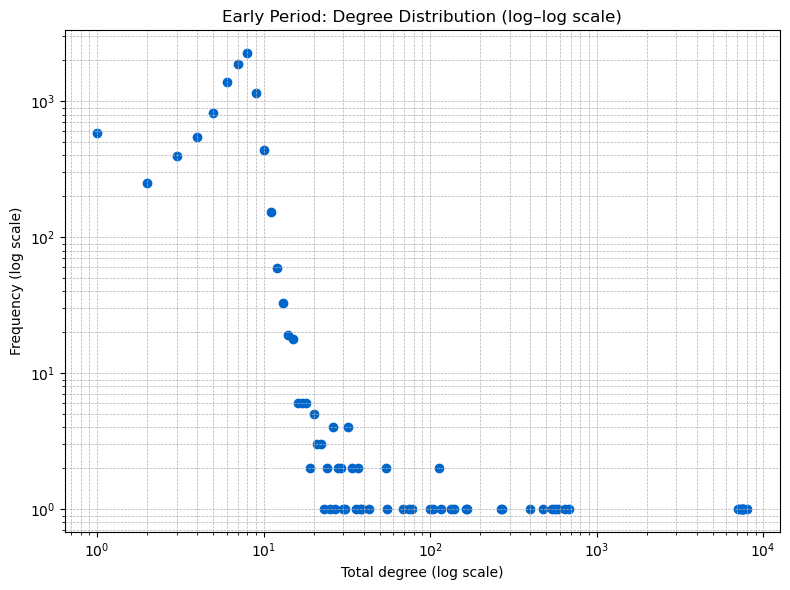


=== Graph Structure Analysis: PEAK ===
Graph summary:
  Nodes: 11,218
  Edges: 77,214
  Total degree — mean: 13.77, min: 1, max: 9092
  In-degree     — mean: 6.88, min: 0, max: 9089
  Out-degree    — mean: 6.88, min: 0, max: 343
  Clustering coefficient (undirected): 0.2247
  Edge density: 0.000614


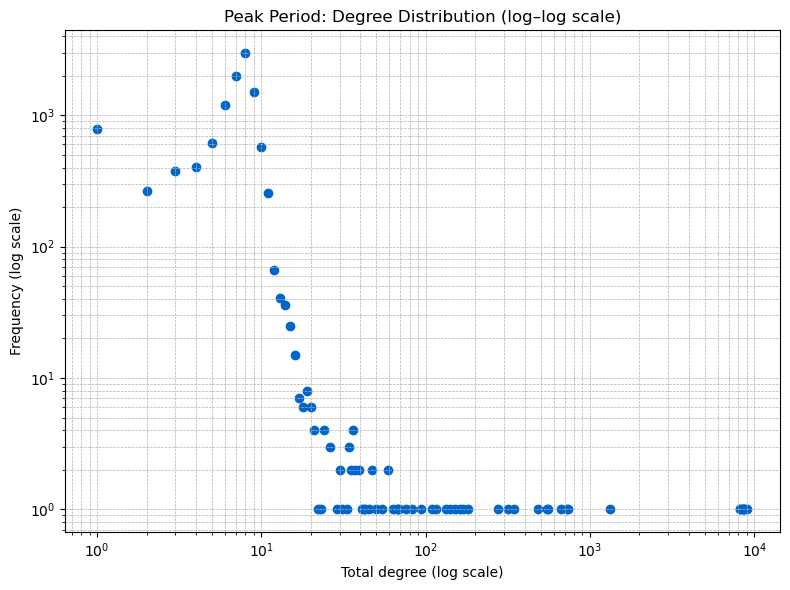


=== Graph Structure Analysis: LATE ===
Graph summary:
  Nodes: 10,809
  Edges: 74,367
  Total degree — mean: 13.76, min: 1, max: 8875
  In-degree     — mean: 6.88, min: 0, max: 8872
  Out-degree    — mean: 6.88, min: 0, max: 141
  Clustering coefficient (undirected): 0.3346
  Edge density: 0.000637


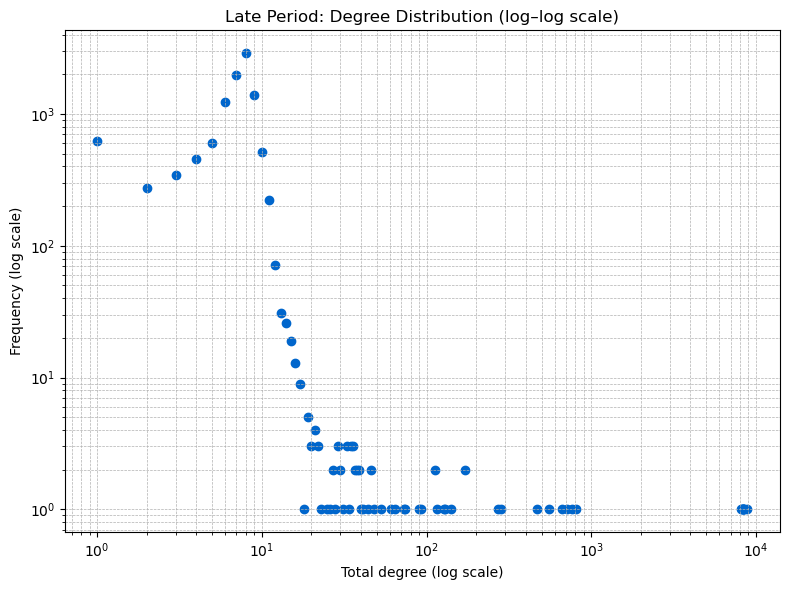


COMPARATIVE GRAPH STRUCTURE SUMMARY


,Period,Nodes,Edges,Avg Degree,Max Degree,Clustering,Density
0,Early,"10,100","66,776",13.22,8055,0.2913,0.000655
1,Peak,"11,218","77,214",13.77,9092,0.2247,0.000614
2,Late,"10,809","74,367",13.76,8875,0.3346,0.000637


In [9]:
def analyse_graph_structure(G, period_name):
    """Analyse structural properties of a computer graph"""
    print(f"\n=== Graph Structure Analysis: {period_name.upper()} ===")
    
    # --- Degree statistics (for DiGraph: use in/out/total) ---
    deg_total_dict = dict(G.degree())
    deg_in_dict    = dict(G.in_degree())
    deg_out_dict   = dict(G.out_degree())

    deg_total_vals = np.fromiter(deg_total_dict.values(), dtype=float)
    deg_in_vals    = np.fromiter(deg_in_dict.values(), dtype=float)
    deg_out_vals   = np.fromiter(deg_out_dict.values(), dtype=float)

    def _safe_stats(arr):
        if arr.size == 0:
            return dict(mean=0.0, min=0, max=0)
        return dict(mean=arr.mean(), min=int(arr.min()), max=int(arr.max()))

    stats_total = _safe_stats(deg_total_vals)
    stats_in    = _safe_stats(deg_in_vals)
    stats_out   = _safe_stats(deg_out_vals)

    # Clustering on undirected projection
    avg_clustering = nx.average_clustering(G.to_undirected())

    # Edge density (for DiGraph: m / (n*(n-1)))
    density = nx.density(G)

    print("Graph summary:")
    print(f"  Nodes: {G.number_of_nodes():,}")
    print(f"  Edges: {G.number_of_edges():,}")
    print(f"  Total degree — mean: {stats_total['mean']:.2f}, min: {stats_total['min']}, max: {stats_total['max']}")
    print(f"  In-degree     — mean: {stats_in['mean']:.2f}, min: {stats_in['min']}, max: {stats_in['max']}")
    print(f"  Out-degree    — mean: {stats_out['mean']:.2f}, min: {stats_out['min']}, max: {stats_out['max']}")
    print(f"  Clustering coefficient (undirected): {avg_clustering:.4f}")
    print(f"  Edge density: {density:.6f}")

    # --- Degree distribution (total degree) on log–log axes ---
    deg_hist = Counter(deg_total_dict.values())
    deg_vals_plot, counts_plot = zip(*sorted(deg_hist.items()))

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(deg_vals_plot, counts_plot, marker='o', color=(0.0, 0.4, 0.8))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Total degree (log scale)')
    ax.set_ylabel('Frequency (log scale)')
    ax.set_title(f'{period_name.title()} Period: Degree Distribution (log–log scale)')
    ax.grid(True, which="both", ls="--", linewidth=0.5)
    fig.tight_layout()

    # --- Save only peak plot as PDF ---
    if period_name.lower() == "peak":
        fig.savefig("peak_degree_distribution.pdf", dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()
    
    return {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'avg_degree': stats_total['mean'],
        'max_degree': stats_total['max'],
        'clustering': avg_clustering,
        'density': density
    }

# Run analysis for all three graphs
graph_stats = {}
for period in ["early", "peak", "late"]:
    if period in computer_graphs:
        graph_stats[period] = analyse_graph_structure(
            computer_graphs[period], period
        )

# Comparative summary
print(f"\n{'='*60}")
print("COMPARATIVE GRAPH STRUCTURE SUMMARY")
print(f"{'='*60}")

summary_data = []
for period in ["early", "peak", "late"]:
    if period in graph_stats:
        stats = graph_stats[period]
        summary_data.append({
            'Period': period.title(),
            'Nodes': f"{stats['nodes']:,}",
            'Edges': f"{stats['edges']:,}",
            'Avg Degree': f"{stats['avg_degree']:.2f}",
            'Max Degree': stats['max_degree'],
            'Clustering': f"{stats['clustering']:.4f}",
            'Density': f"{stats['density']:.6f}"
        })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

### <u>Step 6: SVD Embedding with Symmetrisation</u>

Compute adjacency‑spectral embeddings for each period’s computer graph after controlled symmetrisation, then inspect the spectrum shape and cumulative variance.

---

#### Overview

- **Input:** directed authentication graphs `G_early`, `G_peak`, `G_late` (edges carry `weight` when multiplicity is preserved).
- **Process:** convert to a sparse adjacency, symmetrise by rule, binarise, zero the diagonal, then compute a truncated SVD.
- **Output:** per‑period embedding `X_svd` of dimension `d_embed`, node order, singular values, and the symmetrised sparse matrix.

---

#### Symmetrisation and binarisation

1. **Node ordering**
   - Extract a sorted list of nodes to fix row and column order of the adjacency.

2. **Sparse adjacency**
   - Build `A_w` as a CSR (compressed sparse row) matrix using edge `weight` (shape `n × n`, printed with `nnz` count).

3. **Symmetrisation method** (`sym_method`)
   - `sum`: `A_sym = A_w + A_wᵀ`
   - `max`: `A_sym = max(A_w, A_wᵀ)` elementwise
   - `mean`: `A_sym = 0.5 · (A_w + A_wᵀ)`  
   The code uses `mean` by default.

4. **Binarise and clean**
   - Set all non‑zero entries to `1.0`.  
   - Set diagonal to `0.0` and remove explicit zeros.  
   - Report sparsity and density with respect to `n (n − 1)`.

---

#### Truncated SVD and scree

- Cap `d_max` to `n − 1`, compute the top `d_max` singular triplets via `svds`, then reverse to descending order.  
- **Scree plot**
  - Left axis: singular values `S` with reference vertical lines at components 5 and 10.  
  - Right axis: cumulative variance proxy using `S² / ∑ S²`, reported as a percentage.  
  - A second legend block lists cumulative variance at selected dimensions (for example `d ∈ {2, 5, 10, 15, 20}`).
  - Colour‑blind friendly palette: main series (blue), elbows (magenta and teal), cumulative curve (orange).  
  - Figure saved as `LANL_<period>_Symmetrised_Scree.pdf`.

---

#### Embedding

- Compute the adjacency spectral embedding:
  $$
  X_{\text{svd}} = U_{:, 1:d} \cdot \operatorname{diag}\!\big(\sqrt{S_{1:d}}\big)
  $$
- Print the embedding shape and selected dimension `d_embed`.

---

#### Per‑period artefacts captured

For each available period:

- `embeddings[period]` -> `X_svd` of shape `(n, d_embed)`.  
- `node_lists[period]` -> node order used for matrix rows and columns.  
- `singular_values[period]` -> vector `S` of length `d_max`.  
- `symmetric_matrices[period]` -> CSR matrix `A_sym`.  
- `U_matrices[period]` -> left singular vectors `U`.

These outputs enable downstream analysis such as elbow-/silhouette-/AIC-, BIC-based selection, dimension sensitivity checks, and GMM‑based scoring on `X_svd`.

---


=== SVD Embedding with Symmetrisation: EARLY ===
Number of nodes: 10100
Original adjacency (sparse) shape: (10100, 10100)  nnz=66,776
Symmetrising using method: mean
Sparsity of A: 99.869121%  (nnz=133,496)
Density of A:  0.130879%


/Users/sheed/miniconda3_pics_env/envs/LA2Env/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


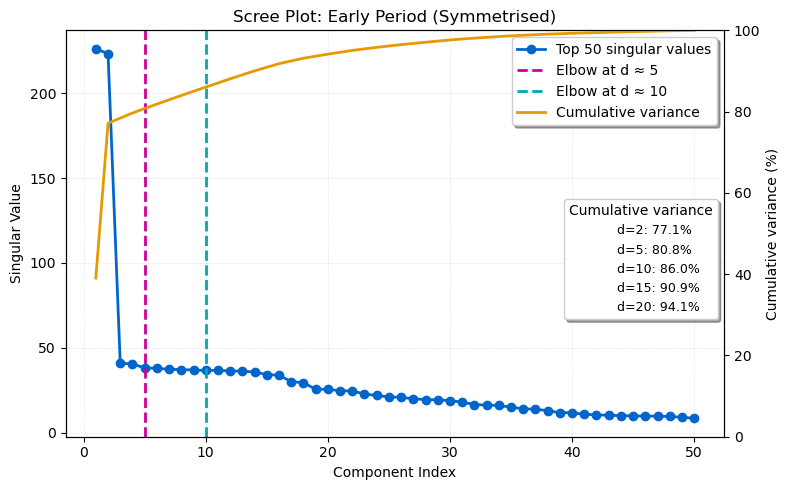

Embedding shape: (10100, 5)
Embedding dimension: 5

=== SVD Embedding with Symmetrisation: PEAK ===
Number of nodes: 11218
Original adjacency (sparse) shape: (11218, 11218)  nnz=77,214
Symmetrising using method: mean
Sparsity of A: 99.877314%  (nnz=154,378)
Density of A:  0.122686%


/Users/sheed/miniconda3_pics_env/envs/LA2Env/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


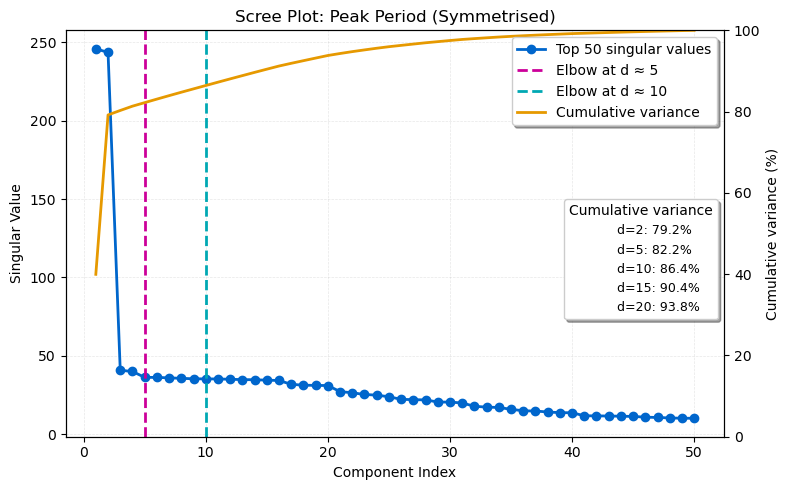

Embedding shape: (11218, 5)
Embedding dimension: 5

=== SVD Embedding with Symmetrisation: LATE ===
Number of nodes: 10809
Original adjacency (sparse) shape: (10809, 10809)  nnz=74,367
Symmetrising using method: mean
Sparsity of A: 99.872719%  (nnz=148,694)
Density of A:  0.127281%


/Users/sheed/miniconda3_pics_env/envs/LA2Env/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


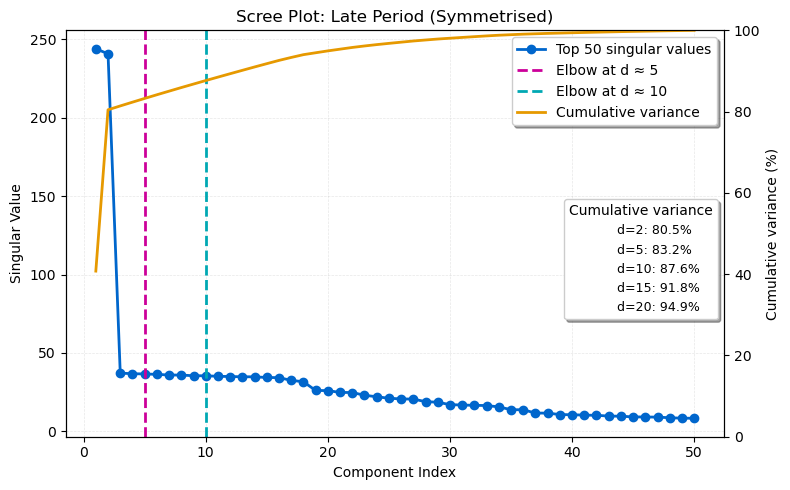

Embedding shape: (10809, 5)
Embedding dimension: 5


In [10]:
def compute_svd_embedding_with_symmetrisation(G, period_name, d_embed=5, d_max=50, 
                                              sym_method='mean'):
    """Compute SVD-based embedding with adjacency matrix symmetrisation"""
    
    print(f"\n=== SVD Embedding with Symmetrisation: {period_name.upper()} ===")
    
    # --- Extract sorted list of nodes to fix row/column order ---
    nodes = sorted(G.nodes())
    print(f"Number of nodes: {len(nodes)}")
    
    # --- Sparse weighted adjacency ---
    A_w = nx.to_scipy_sparse_array(G, nodelist=nodes, weight='weight',
                                   dtype=float, format='csr')
    print(f"Original adjacency (sparse) shape: {A_w.shape}  nnz={A_w.nnz:,}")
    
    # --- Symmetrise the adjacency matrix ---
    print(f"Symmetrising using method: {sym_method}")
    if sym_method == 'sum':
        A_sym = (A_w + A_w.T).tocsr()
    elif sym_method == 'max':
        A_sym = A_w.maximum(A_w.T).tocsr()
    elif sym_method == 'mean':
        A_sym = ((A_w + A_w.T) * 0.5).tocsr()
    else:
        raise ValueError("Method must be 'sum', 'max', or 'mean'")
    
    # --- Binarise in sparse and zero diagonal ---
    A_sym.data[:] = 1.0
    A_sym.setdiag(0.0)
    A_sym.eliminate_zeros()

    # --- Sparsity & cap d_max ---
    n = A_sym.shape[0]              # number of nodes
    if n < 2:
        raise ValueError(f"Graph {period_name} too small for SVD embedding (n={n}).")  # safety check
    nnz = A_sym.nnz                 # number of nonzero entries
    density = nnz / (n * (n - 1))   # exclude diagonal self-loops
    sparsity = 1.0 - density

    print(f"Sparsity of A: {sparsity:.6%}  (nnz={nnz:,})")
    print(f"Density of A:  {density:.6%}")

    # --- Sparse SVD (ascending -> reverse to descending) ---
    d_max = min(d_max, n - 1)
    U, S, VT = svds(A_sym, k=d_max, random_state=42)          # for reproducibility
    U, S, VT = U[:, ::-1], S[::-1], VT[::-1, :]

    # Fix sign consistency
    for i in range(U.shape[1]):
        if U[np.argmax(np.abs(U[:, i])), i] < 0:
            U[:, i] *= -1
    
    # --- Colour-blind friendly colours ---
    color_main = (0.0, 0.4, 0.8)
    color_elbow1 = (0.8, 0.0, 0.6)
    color_elbow2 = (0.0, 0.66, 0.70)
    color_cumvar = (0.9, 0.6, 0.0)
    
    # --- Scree plot ---
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # left axis: singular values
    x = np.arange(1, d_max + 1)
    ax.plot(x, S, marker='o', color=color_main, linewidth=2,
            label=f"Top {d_max} singular values")
    ax.axvline(5,  color=color_elbow1, ls='--', linewidth=2.0, label='Elbow at d ≈ 5')
    ax.axvline(10, color=color_elbow2, ls='--', linewidth=2.0, label='Elbow at d ≈ 10')
    ax.set_title(f"Scree Plot: {period_name.title()} Period (Symmetrised)", fontsize=12)
    ax.set_xlabel("Component Index")
    ax.set_ylabel("Singular Value")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

    # right axis: cumulative explained variance in %
    ax2 = ax.twinx()
    total_var = float(np.sum(S**2))  # safer name + cast
    if total_var > 0:
        ev = (S**2) / total_var
        cumvar = np.cumsum(ev) * 100.0
    else:
        ev = np.zeros_like(S)
        cumvar = np.zeros_like(S)
    ax2.plot(x, cumvar, linestyle='-', linewidth=2, color=color_cumvar, label="Cumulative variance")
    ax2.set_ylabel("Cumulative variance (%)")
    ax2.set_ylim(0, 100)

    # --- Main legend (top right) ---
    lines_left,  labels_left  = ax.get_legend_handles_labels()
    lines_right, labels_right = ax2.get_legend_handles_labels()
    ax2.legend(lines_left + lines_right, labels_left + labels_right,
               frameon=True, fancybox=True, shadow=True, fontsize=10, loc="upper right")

    # --- Explained variance up to 20 components ---
    upto = min(20, len(S)) 
    dims = [d for d in [2, 5, 10, 15, 20] if d <= upto]
    explained_var = (S[:upto]**2) / np.sum(S**2)
    cum_explained = np.cumsum(explained_var)

    rows = [f"d={d}: {cum_explained[d-1]*100:.1f}%" for d in dims]

    # Make fake legend handles (invisible) to format as a legend box
    handles = [plt.Line2D([0], [0], color="none")] * len(rows)
    
    # Format as percentages
    explained_lines = [f"{i+1}: {cum_explained[i]*100:.1f}%" for i in range(len(cum_explained))]
    explained_text = "Cumulative variance (up to 20):\n" + ", ".join(explained_lines)

    # Place as second legend (below main one, portrait style)
    leg2 = ax.legend(
        handles, rows,
        loc="upper right",
        bbox_to_anchor=(1.0, 0.6),  # shift downward
        frameon=True, fancybox=True, shadow=True,
        fontsize=9, title="Cumulative variance"
    )

    
    fig.tight_layout()
    fig.savefig(f"LANL_{period_name}_Symmetrised_Scree.pdf", dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # --- Compute SVD-based embedding ---
    X_svd = U[:, :d_embed] @ np.diag(np.sqrt(S[:d_embed]))
    
    print(f"Embedding shape: {X_svd.shape}")
    print(f"Embedding dimension: {d_embed}")
    
    return X_svd, nodes, S, A_sym, U

# Compute embeddings for all three graphs WITH symmetrisation
embeddings = {}
node_lists = {}
singular_values = {}
symmetric_matrices = {}
U_matrices = {}

for period in ["early", "peak", "late"]:
    if period in computer_graphs:
        X_svd, nodes, S, A_sym, U = compute_svd_embedding_with_symmetrisation(
            computer_graphs[period], 
            period, 
            d_embed=5, # Chosen d
            d_max=50,
            sym_method='mean'
        )
        embeddings[period] = X_svd
        node_lists[period] = nodes
        singular_values[period] = S
        symmetric_matrices[period] = A_sym
        U_matrices[period] = U

#### Plot SVD Embeddings

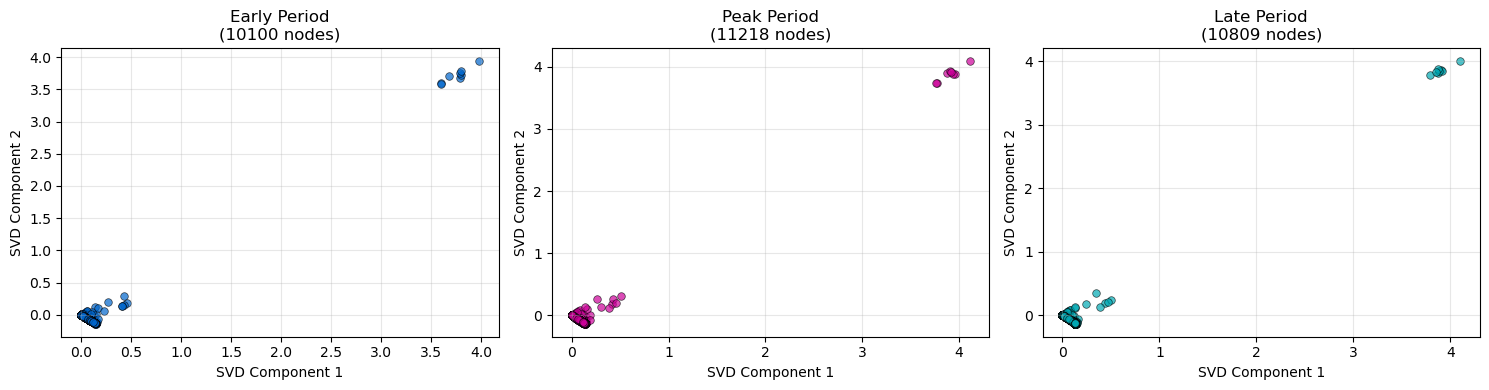

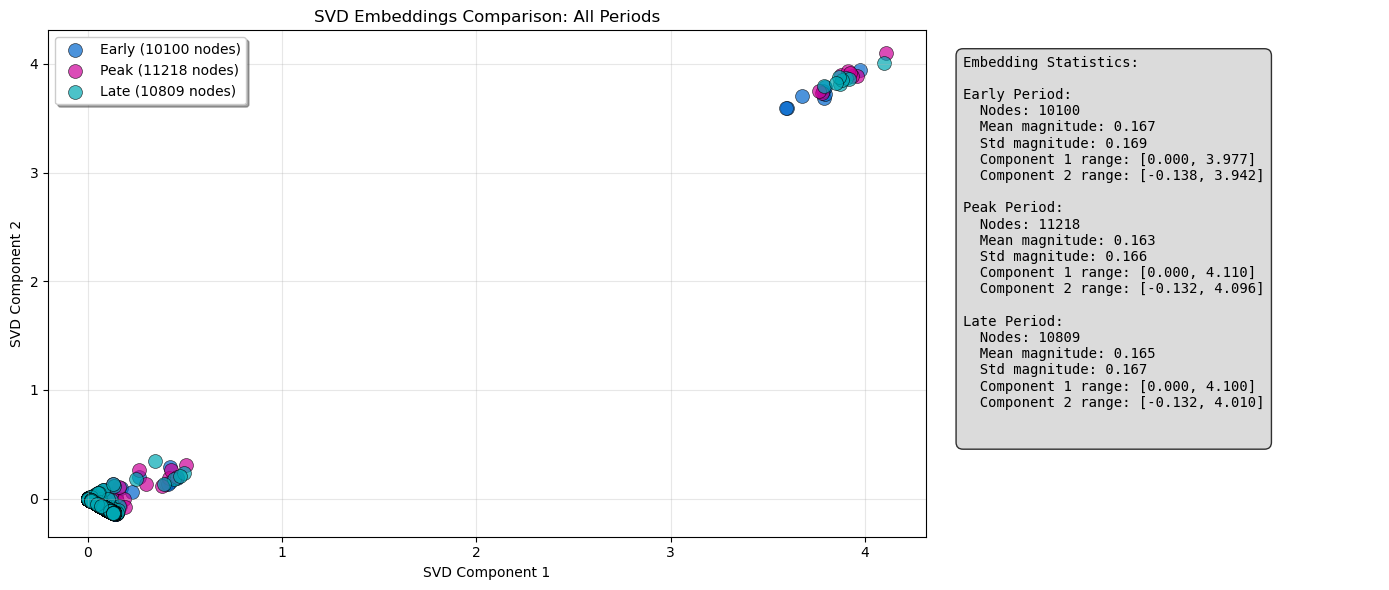

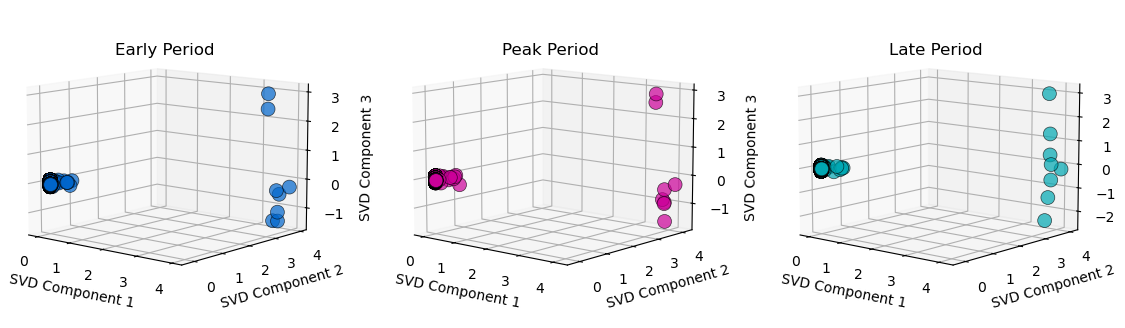

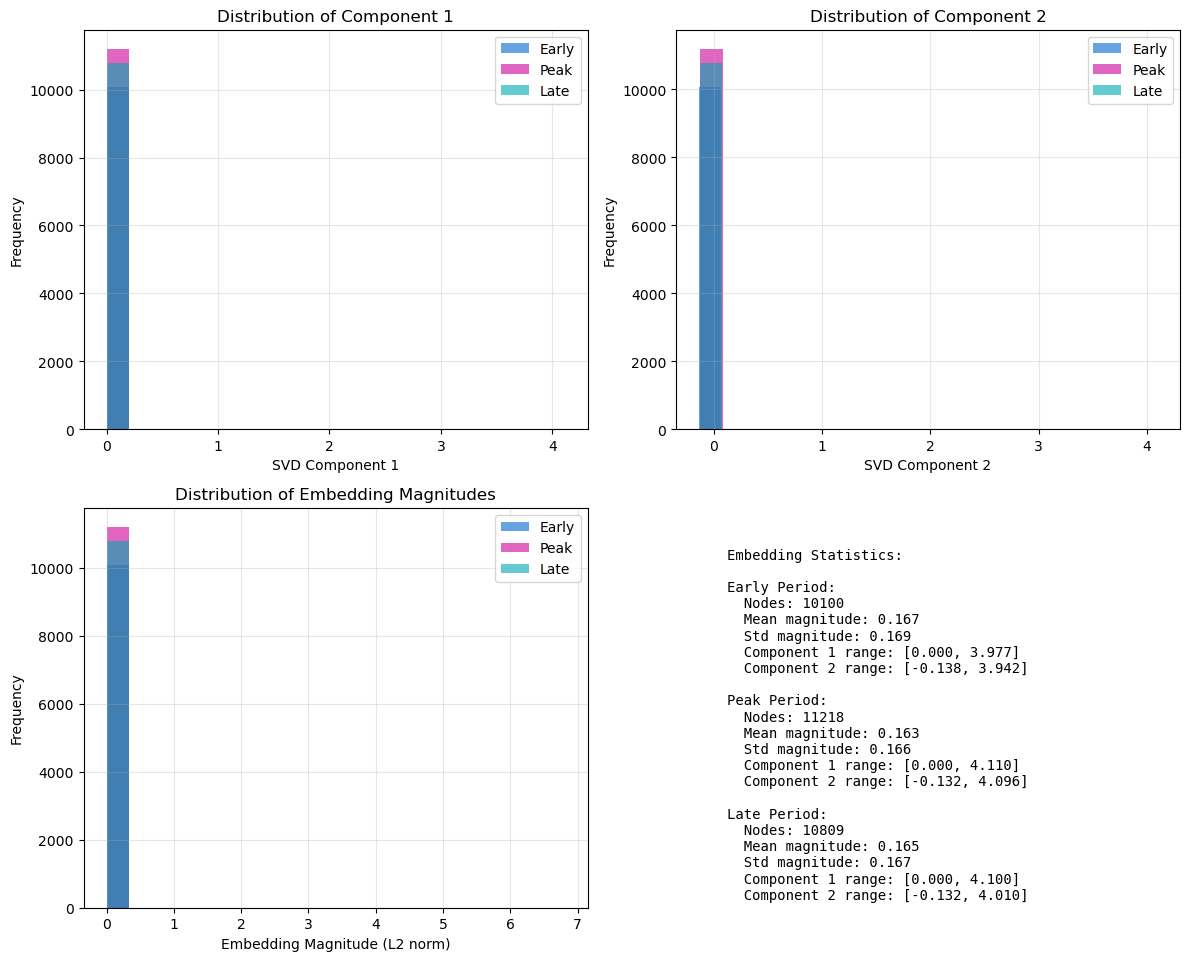

Peak vs Late -> disparity=0.428844, common_nodes=9667, dims=5
Peak vs Early -> disparity=0.286108
Early vs Late -> disparity=0.417823


In [11]:
def plot_svd_embeddings(embeddings, node_lists, periods=None):
    """
    Create scatter plots for SVD embeddings across different time periods
    
    Parameters:
    embeddings: dict with period names as keys and embedding matrices as values
    node_lists: dict with period names as keys and node lists as values  
    periods: list of periods to plot (if None, plots all available periods)
    """
    
    if periods is None:
        periods = list(embeddings.keys())
    
    # Color-blind friendly palette
    colors = {
        'early': (0.0, 0.4, 0.8),    # blue
        'peak': (0.8, 0.0, 0.6),     # magenta  
        'late': (0.0, 0.66, 0.70)    # teal
    }
    
    # 1. 2D scatter plot (first two components)
    fig, axes = plt.subplots(1, len(periods), figsize=(5*len(periods), 4))
    if len(periods) == 1:
        axes = [axes]
    
    for i, period in enumerate(periods):
        if period in embeddings:
            X_svd = embeddings[period]
            ax = axes[i]
            
            ax.scatter(X_svd[:, 0], X_svd[:, 1], 
                      color=colors.get(period, (0.5, 0.5, 0.5)), 
                      alpha=0.7, s=30, edgecolors='black', linewidth=0.5)
            
            ax.set_xlabel('SVD Component 1')
            ax.set_ylabel('SVD Component 2') 
            ax.set_title(f'{period.title()} Period\n({len(X_svd)} nodes)')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('SVD_Embeddings_2D.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. All periods on same 2D plot for comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})
    
    for period in periods:
        if period in embeddings:
            X_svd = embeddings[period]
            ax1.scatter(X_svd[:, 0], X_svd[:, 1],
                       color=colors.get(period, (0.5, 0.5, 0.5)),
                       alpha=0.7, s=100, label=f'{period.title()} ({len(X_svd)} nodes)',
                       edgecolors='black', linewidth=0.5)
    
    ax1.set_xlabel('SVD Component 1')
    ax1.set_ylabel('SVD Component 2')
    ax1.set_title('SVD Embeddings Comparison: All Periods')
    ax1.legend(frameon=True, fancybox=True, shadow=True)
    ax1.grid(True, alpha=0.3)

    # Right subplot: statistics
    ax2.axis('off')

    stats_text = "Embedding Statistics:\n\n"
    for period in periods:
        if period in embeddings:
            X_svd = embeddings[period]
            stats_text += f"{period.title()} Period:\n"
            stats_text += f"  Nodes: {len(X_svd)}\n"
            stats_text += f"  Mean magnitude: {np.mean(np.linalg.norm(X_svd, axis=1)):.3f}\n"
            stats_text += f"  Std magnitude: {np.std(np.linalg.norm(X_svd, axis=1)):.3f}\n"
            stats_text += f"  Component 1 range: [{X_svd[:, 0].min():.3f}, {X_svd[:, 0].max():.3f}]\n"
            stats_text += f"  Component 2 range: [{X_svd[:, 1].min():.3f}, {X_svd[:, 1].max():.3f}]\n\n"

    ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes, 
        verticalalignment='top', fontfamily='monospace', fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('SVD_Embeddings_2D_Combined.pdf', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # 3. 3D scatter plot (first three components)
    fig = plt.figure(figsize=(12, 4))  

    for i, period in enumerate(periods):
        if period in embeddings:
            X_svd = embeddings[period]

            ax = fig.add_subplot(1, len(periods), i+1, projection='3d')
            ax.scatter(X_svd[:, 0], X_svd[:, 1], X_svd[:, 2],
                       color=colors.get(period, (0.5, 0.5, 0.5)),
                       alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
            
            ax.view_init(elev=10, azim=-50)
            ax.set_xlabel('SVD Component 1')
            ax.set_ylabel('SVD Component 2')
            ax.set_zlabel('SVD Component 3')
            ax.set_title(f'{period.title()} Period', y=0.90)

    # manually adjust spacing to prevent label cut-off
    fig.subplots_adjust(left=0.0, right=0.90, bottom=0.0, top=0.9, wspace=0.25)

    plt.savefig('SVD_Embeddings_3D.pdf', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # 4. Component magnitude analysis
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Component distributions
    for i, comp in enumerate([0, 1]):
        ax = axes[0, i]
        for period in periods:
            if period in embeddings:
                X_svd = embeddings[period]
                ax.hist(X_svd[:, comp], alpha=0.6, bins=20, 
                       label=f'{period.title()}', 
                       color=colors.get(period, (0.5, 0.5, 0.5)))
        
        ax.set_xlabel(f'SVD Component {comp+1}')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of Component {comp+1}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Component magnitudes (L2 norms)
    ax = axes[1, 0]
    for period in periods:
        if period in embeddings:
            X_svd = embeddings[period]
            norms = np.linalg.norm(X_svd, axis=1)
            ax.hist(norms, alpha=0.6, bins=20, 
                   label=f'{period.title()}', 
                   color=colors.get(period, (0.5, 0.5, 0.5)))
    
    ax.set_xlabel('Embedding Magnitude (L2 norm)')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Embedding Magnitudes')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Summary statistics
    ax = axes[1, 1]
    ax.axis('off')
    
    stats_text = "Embedding Statistics:\n\n"
    for period in periods:
        if period in embeddings:
            X_svd = embeddings[period]
            stats_text += f"{period.title()} Period:\n"
            stats_text += f"  Nodes: {len(X_svd)}\n"
            stats_text += f"  Mean magnitude: {np.mean(np.linalg.norm(X_svd, axis=1)):.3f}\n"
            stats_text += f"  Std magnitude: {np.std(np.linalg.norm(X_svd, axis=1)):.3f}\n"
            stats_text += f"  Component 1 range: [{X_svd[:, 0].min():.3f}, {X_svd[:, 0].max():.3f}]\n"
            stats_text += f"  Component 2 range: [{X_svd[:, 1].min():.3f}, {X_svd[:, 1].max():.3f}]\n\n"
    
    ax.text(0.1, 0.9, stats_text, transform=ax.transAxes, 
            verticalalignment='top', fontfamily='monospace', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('SVD_Embeddings_Analysis.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Usage with our embeddings:
plot_svd_embeddings(embeddings, node_lists)

# Procrustes analysis to compute similarities/disparities
def procrustes_between(period_a, period_b, embeddings, node_lists):
    """
    Align by common nodes and compute Procrustes disparity.
    """
    nodes_a = node_lists[period_a]
    nodes_b = node_lists[period_b]
    common = sorted(set(nodes_a).intersection(nodes_b))
    if not common:
        raise ValueError("No common nodes between the two periods.")

    # index maps
    idx_a = {n: i for i, n in enumerate(nodes_a)}
    idx_b = {n: i for i, n in enumerate(nodes_b)}

    Xa_full = embeddings[period_a]
    Xb_full = embeddings[period_b]

    # subset rows to common nodes in the same order
    Xa = Xa_full[[idx_a[n] for n in common], :]
    Xb = Xb_full[[idx_b[n] for n in common], :]

    # match dimensionality (Procrustes needs same #cols)
    d = min(Xa.shape[1], Xb.shape[1])
    Xa, Xb = Xa[:, :d], Xb[:, :d]

    # run Procrustes (scale/translate/rotate reflection-invariant)
    _, _, disparity = procrustes(Xa, Xb)
    return disparity, len(common), d

# Run disparity calc
disp_pl, n_common, d_used = procrustes_between('peak', 'late', embeddings, node_lists)
print(f"Peak vs Late -> disparity={disp_pl:.6f}, common_nodes={n_common}, dims={d_used}")

disp_pe, _, _ = procrustes_between('peak', 'early', embeddings, node_lists)
disp_el, _, _ = procrustes_between('early', 'late', embeddings, node_lists)
print(f"Peak vs Early -> disparity={disp_pe:.6f}")
print(f"Early vs Late -> disparity={disp_el:.6f}")

### <u>Step 7: Cluster Number Selection on SVD Embeddings</u>

Select the number of clusters \(k\) for each period’s embedding using three criteria, with consistent colour‑blind friendly styling.

---

#### Procedure

1. **Standardisation**
   - Standardise each period’s embedding with `StandardScaler` prior to clustering to stabilise inertia, silhouette, and GMM fitting.

2. **Models per $k \in \{2,\dots,10\} $**  
   - **K‑Means:** record inertia and compute **silhouette** on the standardised embedding.  
   - **GMM (covariance = `full` by default):** compute **AIC** and **BIC** on the standardised embedding.  
   - Track the best silhouette \(k\) and the minima for AIC and BIC.  
   - K‑Means uses `n_init="auto"` when available, otherwise falls back to `n_init=10` for older scikit‑learn versions.

3. **Visual summary (1 × 3 figure per period)**
   - **Left:** K‑Means inertia curve (elbow view).  
   - **Middle:** Silhouette scores with the best \(k\) marked in **magenta**.  
   - **Right:** GMM AIC and BIC curves with minima marked in **orange** (AIC) and **blue** (BIC).  
   - Figures saved as `k_selection_<Period>.pdf`.

4. **Console report**
   - Best \(k\) by silhouette and the \(k\) values achieving minimum AIC and minimum BIC, with scores.

---

#### Outputs

- Three PDFs, one per period, showing inertia, silhouette, and AIC/BIC trends.  
- Printed summary of recommended \(k\) values by each criterion for Early, Peak, and Late embeddings.

---

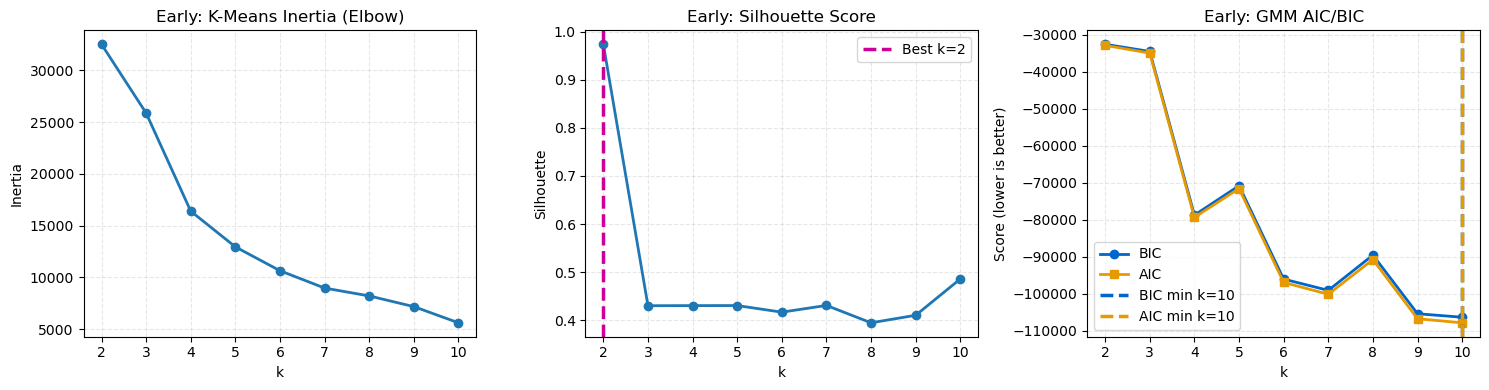

[Early] Best silhouette k = 2 (score=0.974)
[Early] Min BIC at k = 10 (BIC=-106405.5)
[Early] Min AIC at k = 10 (AIC=-107914.5)


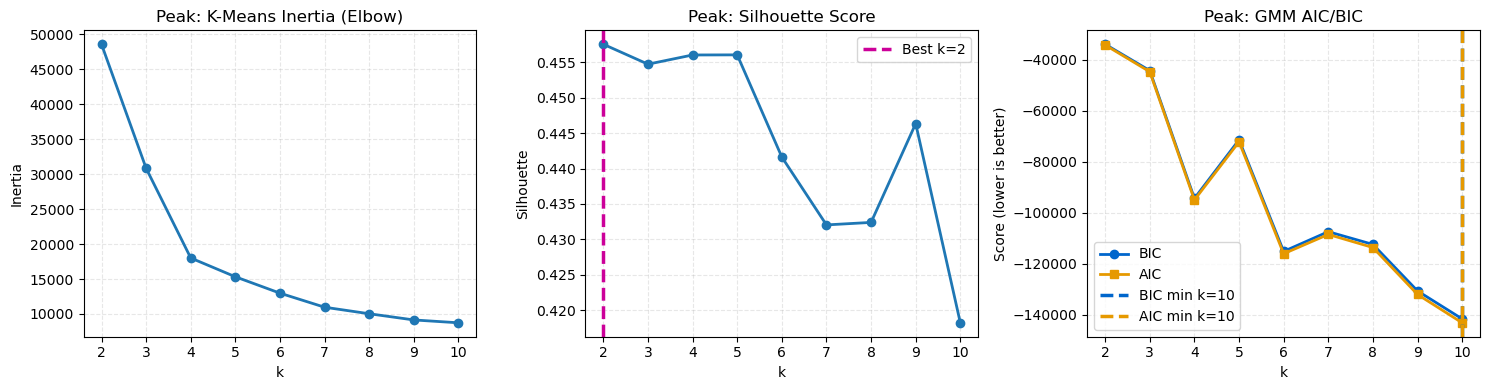

[Peak] Best silhouette k = 2 (score=0.458)
[Peak] Min BIC at k = 10 (BIC=-141706.7)
[Peak] Min AIC at k = 10 (AIC=-143237.7)


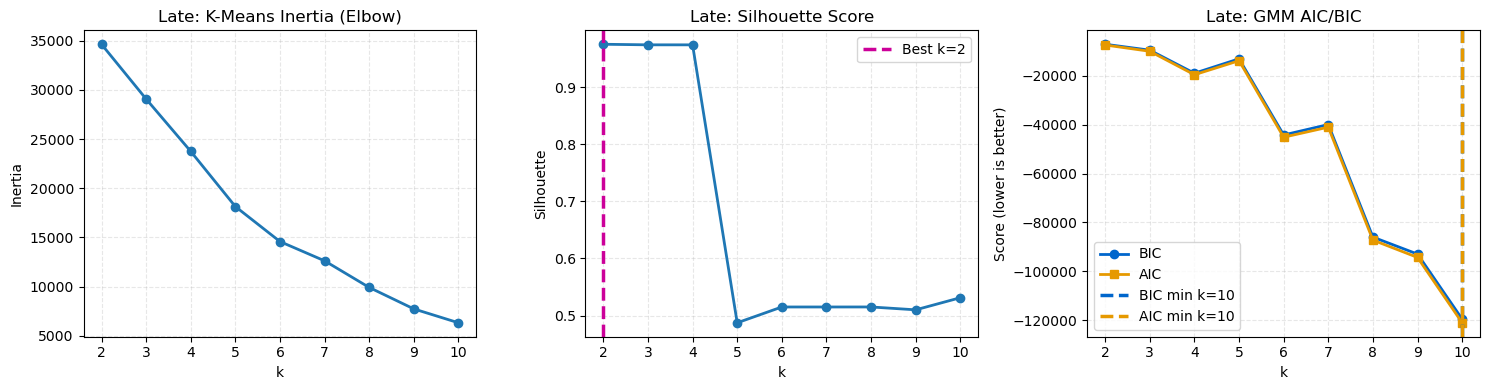

[Late] Best silhouette k = 2 (score=0.975)
[Late] Min BIC at k = 10 (BIC=-119505.6)
[Late] Min AIC at k = 10 (AIC=-121028.8)


In [12]:
# --- Colour-blind friendly palette ---
COLOR_SIL = (0.8, 0.0, 0.6)   # magenta
COLOR_BIC = (0.0, 0.4, 0.8)   # blue
COLOR_AIC = (0.9, 0.6, 0.0)   # orange

def _fit_kmeans(Xs, k, seed=42):
    try:
        return KMeans(n_clusters=k, n_init="auto", init="k-means++", random_state=seed).fit(Xs)
    except TypeError:  # older sklearn
        return KMeans(n_clusters=k, n_init=10, init="k-means++", random_state=seed).fit(Xs)

def run_k_selection(X, label, savefile, Ks=range(2, 11), gmm_cov="full", seed=42):
    """
    X : (n,d) embedding for one period
    label : 'Early'|'Peak'|'Late' (used in titles)
    savefile : path to save the 1x3 PDF
    """
    # Standardise for stability
    Xs = StandardScaler().fit_transform(X)
    n_samples = Xs.shape[0]

    # guard: k must be < n_samples for KMeans/GMM; keep k>=2
    Ks = [k for k in Ks if 2 <= k <= max(2, n_samples - 1)]
    if not Ks:
        raise ValueError(f"{label}: no valid k in Ks for n={n_samples}")
    
    inertias, sil_scores, aics, bics = [], [], [], []
    best_sil, best_k_sil = -1.0, None

    for k in Ks:
        # --- KMeans ---
        km = _fit_kmeans(Xs, k, seed=seed)
        inertias.append(km.inertia_)
        
        # silhouette can fail if data collapse (rare)/defensive
        try:
            sil = float(silhouette_score(Xs, km.labels_))
        except Exception:
            sil = np.nan
        sil_scores.append(sil)
        if np.isfinite(sil) and sil > best_sil:
            best_sil, best_k_sil = sil, k

        # --- GMM ---
        gmm = GaussianMixture(
            n_components=k, covariance_type=gmm_cov,
            reg_covar=1e-6, n_init=10, max_iter=1000,
            init_params="kmeans", random_state=seed
        ).fit(Xs)
        aics.append(gmm.aic(Xs))
        bics.append(gmm.bic(Xs))

    # Min AIC/BIC
    min_bic = float(np.min(bics)); min_bic_k = Ks[int(np.argmin(bics))]
    min_aic = float(np.min(aics)); min_aic_k = Ks[int(np.argmin(aics))]

    # --- Plot row (1x3) ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    ax = axes[0]
    ax.plot(Ks, inertias, marker='o', linewidth=2)
    ax.set_title(f"{label}: K-Means Inertia (Elbow)")
    ax.set_xlabel("k"); ax.set_ylabel("Inertia")
    ax.grid(True, linestyle='--', alpha=0.3)

    ax = axes[1]
    ax.plot(Ks, sil_scores, marker='o', linewidth=2)
    if best_k_sil is not None:  # only draw if computed
        ax.axvline(x=best_k_sil, linestyle='--', color=COLOR_SIL, linewidth=2.5,
                   label=f'Best k={best_k_sil}')
    ax.set_title(f"{label}: Silhouette Score")
    ax.set_xlabel("k"); ax.set_ylabel("Silhouette")
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend()

    ax = axes[2]
    ax.plot(Ks, bics, marker='o', linewidth=2, label="BIC", color=COLOR_BIC)
    ax.plot(Ks, aics, marker='s', linewidth=2, label="AIC", color=COLOR_AIC)
    ax.axvline(x=min_bic_k, linestyle='--', color=COLOR_BIC, linewidth=2.5,
               label=f'BIC min k={min_bic_k}')
    ax.axvline(x=min_aic_k, linestyle='--', color=COLOR_AIC, linewidth=2.5,
               label=f'AIC min k={min_aic_k}')
    ax.set_title(f"{label}: GMM AIC/BIC")
    ax.set_xlabel("k"); ax.set_ylabel("Score (lower is better)")
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend()

    fig.tight_layout()
    fig.savefig(savefile, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    # Console summary
    print(f"[{label}] Best silhouette k = {best_k_sil} (score={best_sil:.3f})")
    print(f"[{label}] Min BIC at k = {min_bic_k} (BIC={min_bic:.1f})")
    print(f"[{label}] Min AIC at k = {min_aic_k} (AIC={min_aic:.1f})")

# ========= Run for the three periods =========
run_k_selection(embeddings["early"], "Early", "k_selection_Early.pdf")
run_k_selection(embeddings["peak"],  "Peak",  "k_selection_Peak.pdf")
run_k_selection(embeddings["late"],  "Late",  "k_selection_Late.pdf")

### <u>Step 8: Embedding Dimension and Clustering Exploration</u>

Evaluate how the choice of **embedding dimension** \(d\) and **cluster count** \(k\) affects structure captured in SVD embeddings, then inspect clustering quality and entropy patterns with red team overlays.

---

#### A. Test embedding dimensions
- Construct $X_{\text{svd}} = U_{:,1:d}\,\mathrm{diag}\!\big(\sqrt{S_{1:d}}\big) \text{ for } d \in \{3,5,7,10\}$.
- Report the cumulative variance proxy $\sum_{i=1}^{d} S_i^2 \,/\, \sum_{i} S_i^2$ and the resulting shape.

#### B. Search \(k\) across dimensions
- For each period and each available \(d\), fit:
  - **KMeans** and compute **silhouette** on labels.
  - **GMM** and record **AIC** and **BIC**.
- Print the best \(k\) by silhouette, and the minima for AIC and BIC for each $(\text{period}, d)$.

#### C. Summarise optimal \(d,k\)
- Collate, per period, the best \(k\) by each metric over $d \in \{3,5,7,10\}$.
- Identify the overall best silhouette combination and report scores.

#### D. Detailed clustering analysis per configuration
For a chosen \(d,k\) and period:
- **Projection for plotting:** apply PCA to $X_{\text{svd}}$ to obtain a 2D view used only for visualisation.
- **Clustering:**
  - Fit **KMeans** and report the silhouette score; draw cluster centroids in the 2D view.
  - Fit **GMM** and report silhouette, **AIC**, and **BIC**.
- **Entropy from GMM:**
  - Compute per‑node entropy from mixture posteriors.
  - Mark the top‑\(K\) highest entropy nodes.
- **Red team overlays:**
  - Red team computers highlighted in **magenta**.
  - High entropy highlights drawn in **teal** with hollow markers.
  - Colour bar shows the entropy scale for normal nodes.
- **Cluster composition table:**
  - For each KMeans cluster, report size, red team count, and red proportion.
- **Statistics:**
  - Print entropy range, mean, and standard deviation.
  - Print red team and normal mean entropy.

Two configurations are executed across all periods:
- **Binary Classification:** \(d=3, k=2\).  
- **Mixed Membership:** \(d=7, k=10\) (guided by earlier AIC and BIC trends).

#### E. Comparative summary
- Assemble a table across configurations and periods with:
  - \(d\), \(k\), KMeans silhouette, GMM silhouette, GMM AIC, and entropy range.

---

#### Outputs
- Printed variance summaries for tested dimensions.
- For each $(\text{period}, d)$, best \(k\) by silhouette and minima for AIC and BIC.
- Per‑period configuration figures saved as `Fig_<period>_<config>_d<d>_k<k>.pdf`.
- A final summary DataFrame comparing clustering quality and entropy ranges across periods and configurations.

---

#### Test Embedding Dimensions

In [13]:
# Test different embedding dimensions
def test_embedding_dimensions(U, S, dims_to_test=[3, 5, 7, 10]):
    """Test different embedding dimensions"""
    embeddings_by_dim = {}

    # precompute total variance once; guard divide-by-zero
    total_var = float(np.sum(S**2))
    if total_var <= 0:
        print("Warning: total variance is zero; explained variance will be 0.0")
        total_var = 1.0

    # cap dims to available components and keep unique, sorted
    max_d = int(min(U.shape[1], len(S)))
    dims = sorted({d for d in dims_to_test if 1 <= d <= max_d})

    for d in dims:
        X_svd = U[:, :d] @ np.diag(np.sqrt(S[:d]))
        embeddings_by_dim[d] = X_svd

        explained_var = float(np.sum(S[:d]**2) / total_var)
        print(f"d={d}: {X_svd.shape}, explained variance: {explained_var:.1%}")

    return embeddings_by_dim

# Test different dimensions for each period
embeddings_by_dimension = {}
for period in ["early", "peak", "late"]:
    if period in U_matrices:
        print(f"\nTesting dimensions for {period.upper()}:")
        embeddings_by_dimension[period] = test_embedding_dimensions(
            U_matrices[period], 
            singular_values[period], 
            dims_to_test=[3, 5, 7, 10]
        )


Testing dimensions for EARLY:
d=3: (10100, 3), explained variance: 78.4%
d=5: (10100, 5), explained variance: 80.8%
d=7: (10100, 7), explained variance: 82.9%
d=10: (10100, 10), explained variance: 86.0%

Testing dimensions for PEAK:
d=3: (11218, 3), explained variance: 80.3%
d=5: (11218, 5), explained variance: 82.2%
d=7: (11218, 7), explained variance: 83.9%
d=10: (11218, 10), explained variance: 86.4%

Testing dimensions for LATE:
d=3: (10809, 3), explained variance: 81.4%
d=5: (10809, 5), explained variance: 83.2%
d=7: (10809, 7), explained variance: 85.0%
d=10: (10809, 10), explained variance: 87.6%


#### Search \(k\) Across Dimensions - Optimal \(d, k\) Combination

In [14]:
def _score_kmeans_gmm(X, k, seed=42):
    """Run KMeans and GMM for a given k and return metrics."""
    scores = {}
    if k < 2 or k >= len(X):
        return {'silhouette': np.nan, 'aic': np.inf, 'bic': np.inf}

    # KMeans + Silhouette
    km = KMeans(n_clusters=k, random_state=seed, n_init=10).fit(X)
    try:
        scores['silhouette'] = silhouette_score(X, km.labels_)
    except Exception:
        scores['silhouette'] = np.nan

    # GMM + AIC/BIC
    gmm = GaussianMixture(
        n_components=k, random_state=seed,
        reg_covar=1e-6, n_init=10, 
        init_params="kmeans", max_iter=1000
    ).fit(X)
    scores['aic'] = gmm.aic(X)
    scores['bic'] = gmm.bic(X)

    return scores


def test_k_across_dimensions(embeddings_by_dimension, dims=(3, 5, 7, 10), k_range=range(2, 11)):
    """Test different k values across embedding dimensions."""
    results = {}

    for period, by_dim in embeddings_by_dimension.items():
        print(f"\n=== Testing k for {period.upper()} across dimensions ===")
        results[period] = {}

        for d in dims:
            if d not in by_dim:
                continue
            X = by_dim[d]
            scores_by_k = {k: _score_kmeans_gmm(X, k) for k in k_range}

            # Collect into arrays for plotting/analysis
            silhouettes = [scores_by_k[k]['silhouette'] for k in k_range]
            aics = [scores_by_k[k]['aic'] for k in k_range]
            bics = [scores_by_k[k]['bic'] for k in k_range]

            # Best k’s
            best_sil_k = k_range[int(np.nanargmax(silhouettes))]
            best_aic_k = k_range[int(np.nanargmin(aics))]
            best_bic_k = k_range[int(np.nanargmin(bics))]

            results[period][d] = {
                'k_range': list(k_range),
                'silhouette': silhouettes,
                'aic': aics,
                'bic': bics,
                'best': {
                    'silhouette': (best_sil_k, np.nanmax(silhouettes)),
                    'aic': (best_aic_k, np.nanmin(aics)),
                    'bic': (best_bic_k, np.nanmin(bics)),
                }
            }

    return results


def find_best_combinations(results):
    """Summarise best (d, k) combinations per metric for each period."""
    print(f"\n{'='*80}\nOPTIMAL (d, k) COMBINATIONS SUMMARY\n{'='*80}")

    for period, dims in results.items():
        print(f"\n{period.upper()} PERIOD:")
        # all best silhouette combos for this period
        sil_combos = [(d, v['best']['silhouette']) for d, v in dims.items()]
        best_d, (best_k, best_score) = max(sil_combos, key=lambda x: x[1][1])
        for d, v in dims.items():
            print(f"  d={d}: Silhouette k={v['best']['silhouette'][0]} "
                  f"({v['best']['silhouette'][1]:.3f}), "
                  f"AIC k={v['best']['aic'][0]} ({v['best']['aic'][1]:.1f}), "
                  f"BIC k={v['best']['bic'][0]} ({v['best']['bic'][1]:.1f})")
        print(f"  -> BEST SILHOUETTE: d={best_d}, k={best_k} "
              f"(score={best_score:.3f})")

In [15]:
# 1. Run the systematic test across dimensions and k’s
optimisation_results = test_k_across_dimensions(
    embeddings_by_dimension,
    dims=[3, 5, 7, 10],   # dimensions we're testing
    k_range=range(2, 11)  # candidate k’s
)

# 2. Print a clean summary
find_best_combinations(optimisation_results)


=== Testing k for EARLY across dimensions ===

=== Testing k for PEAK across dimensions ===

=== Testing k for LATE across dimensions ===

OPTIMAL (d, k) COMBINATIONS SUMMARY

EARLY PERIOD:
  d=3: Silhouette k=2 (0.985), AIC k=10 (-225506.8), BIC k=10 (-224792.0)
  d=5: Silhouette k=2 (0.980), AIC k=10 (-353179.7), BIC k=10 (-351670.6)
  d=7: Silhouette k=2 (0.977), AIC k=10 (-457665.7), BIC k=10 (-455073.6)
  d=10: Silhouette k=2 (0.974), AIC k=7 (-652417.4), BIC k=7 (-649088.9)
  -> BEST SILHOUETTE: d=3, k=2 (score=0.985)

PEAK PERIOD:
  d=3: Silhouette k=2 (0.986), AIC k=9 (-257517.3), BIC k=9 (-256865.4)
  d=5: Silhouette k=2 (0.982), AIC k=9 (-405772.4), BIC k=9 (-404395.3)
  d=7: Silhouette k=2 (0.978), AIC k=10 (-514585.4), BIC k=10 (-511955.6)
  d=10: Silhouette k=2 (0.975), AIC k=10 (-729707.3), BIC k=10 (-724879.9)
  -> BEST SILHOUETTE: d=3, k=2 (score=0.986)

LATE PERIOD:
  d=3: Silhouette k=2 (0.987), AIC k=10 (-247976.6), BIC k=9 (-247278.3)
  d=5: Silhouette k=2 (0.982),

#### Detailed Clustering Analysis Per Configuration


EARLY - Binary Classification (d=3, k=2)
KMeans Silhouette Score for k=2: 0.985
GMM Silhouette Score for k=2: 0.866
GMM AIC: -177726.8
GMM BIC: -177589.7


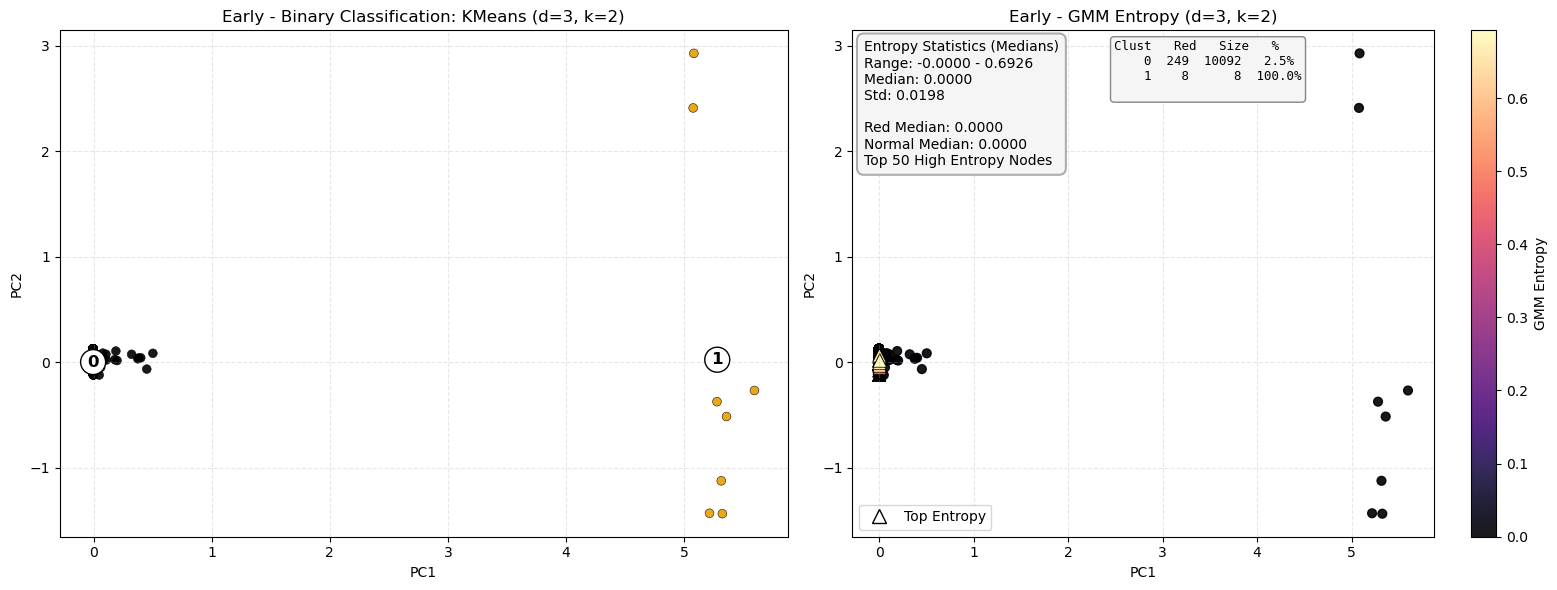


Red Team Distribution by Cluster:


,Cluster,Red Team Count,Cluster Size,Red %
0,0,249,10092,2.5%
1,1,8,8,100.0%



PEAK - Binary Classification (d=3, k=2)
KMeans Silhouette Score for k=2: 0.986
GMM Silhouette Score for k=2: 0.876
GMM AIC: -199023.7
GMM BIC: -198884.6


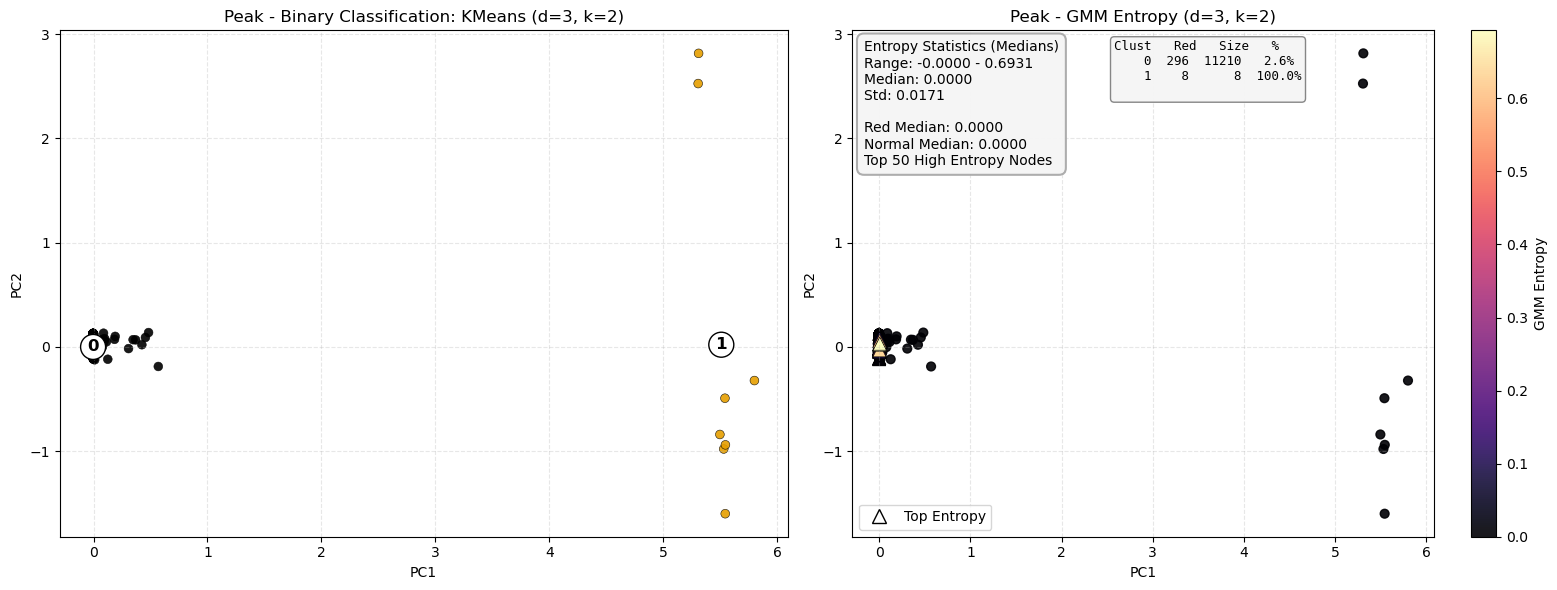


Red Team Distribution by Cluster:


,Cluster,Red Team Count,Cluster Size,Red %
0,0,296,11210,2.6%
1,1,8,8,100.0%



LATE - Binary Classification (d=3, k=2)
KMeans Silhouette Score for k=2: 0.987
GMM Silhouette Score for k=2: 0.891
GMM AIC: -193653.3
GMM BIC: -193514.8


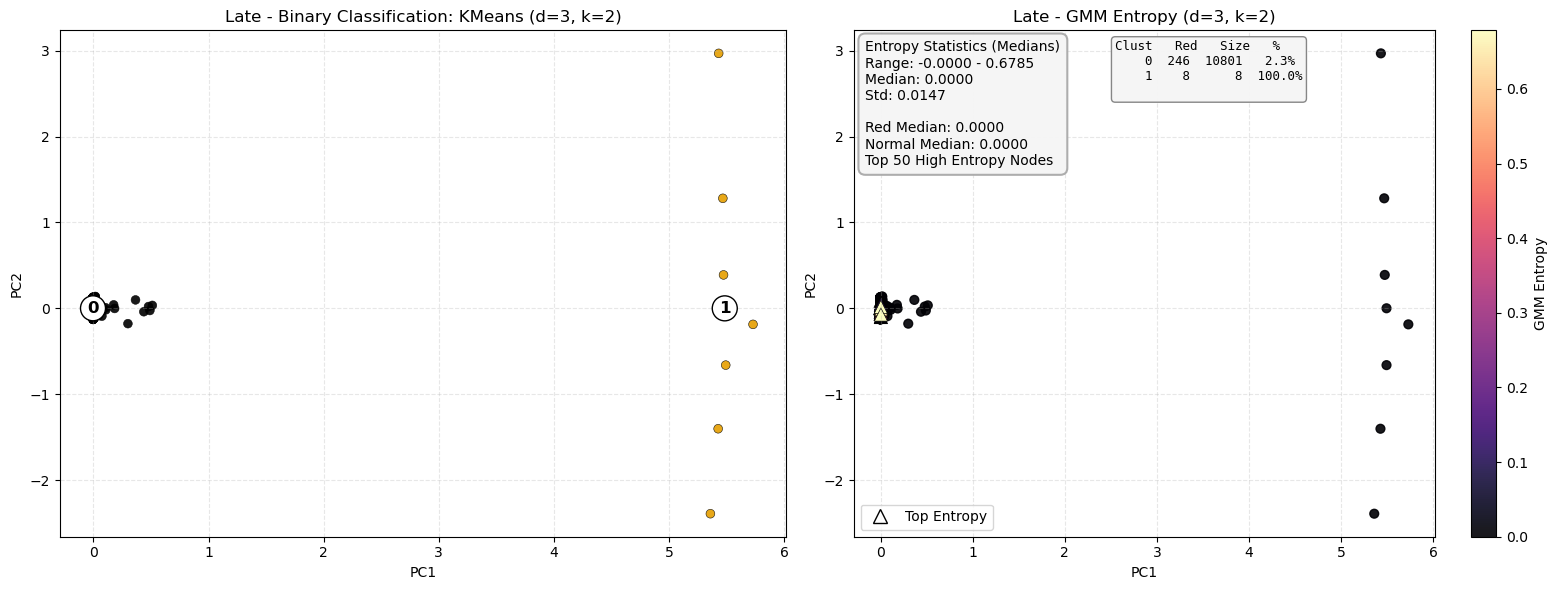


Red Team Distribution by Cluster:


,Cluster,Red Team Count,Cluster Size,Red %
0,0,246,10801,2.3%
1,1,8,8,100.0%



EARLY - Mixed Membership (d=7, k=10)
KMeans Silhouette Score for k=10: 0.321
GMM Silhouette Score for k=10: 0.157
GMM AIC: -457665.7
GMM BIC: -455073.6


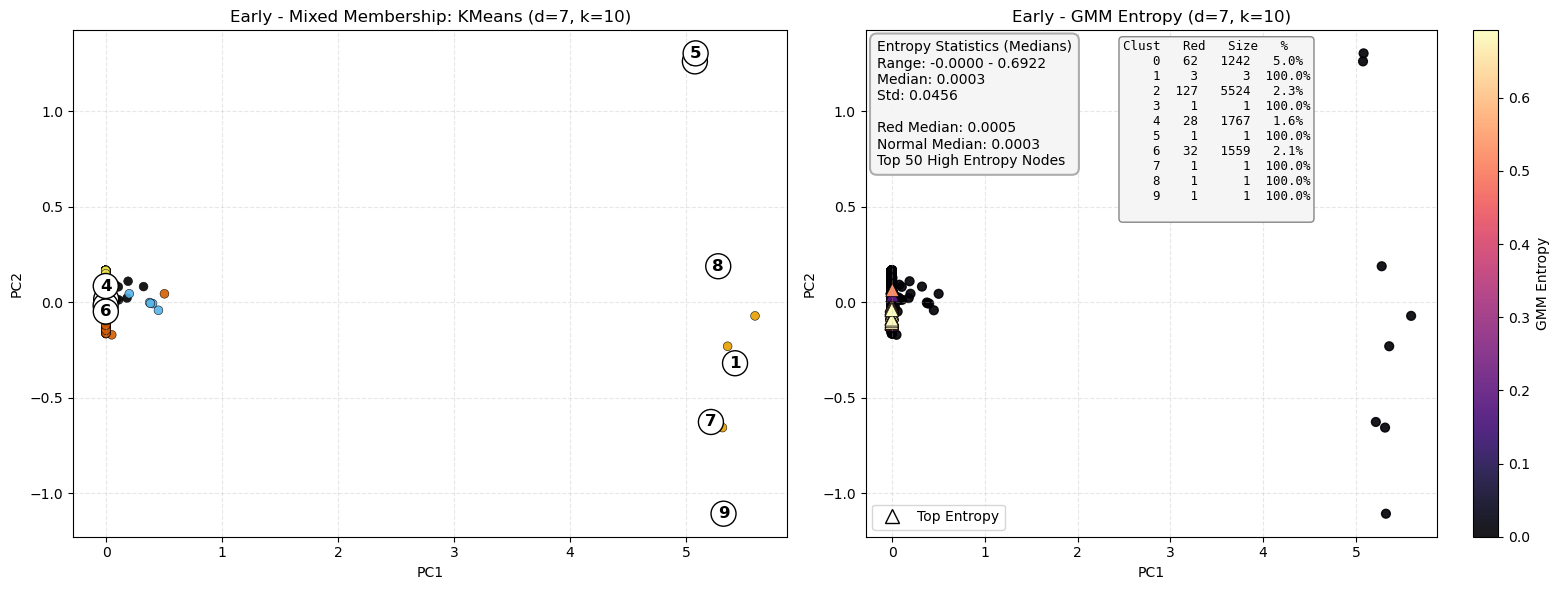


Red Team Distribution by Cluster:


,Cluster,Red Team Count,Cluster Size,Red %
0,0,62,1242,5.0%
1,1,3,3,100.0%
2,2,127,5524,2.3%
3,3,1,1,100.0%
4,4,28,1767,1.6%
5,5,1,1,100.0%
6,6,32,1559,2.1%
7,7,1,1,100.0%
8,8,1,1,100.0%
9,9,1,1,100.0%



PEAK - Mixed Membership (d=7, k=10)
KMeans Silhouette Score for k=10: 0.385
GMM Silhouette Score for k=10: 0.255
GMM AIC: -514585.4
GMM BIC: -511955.6


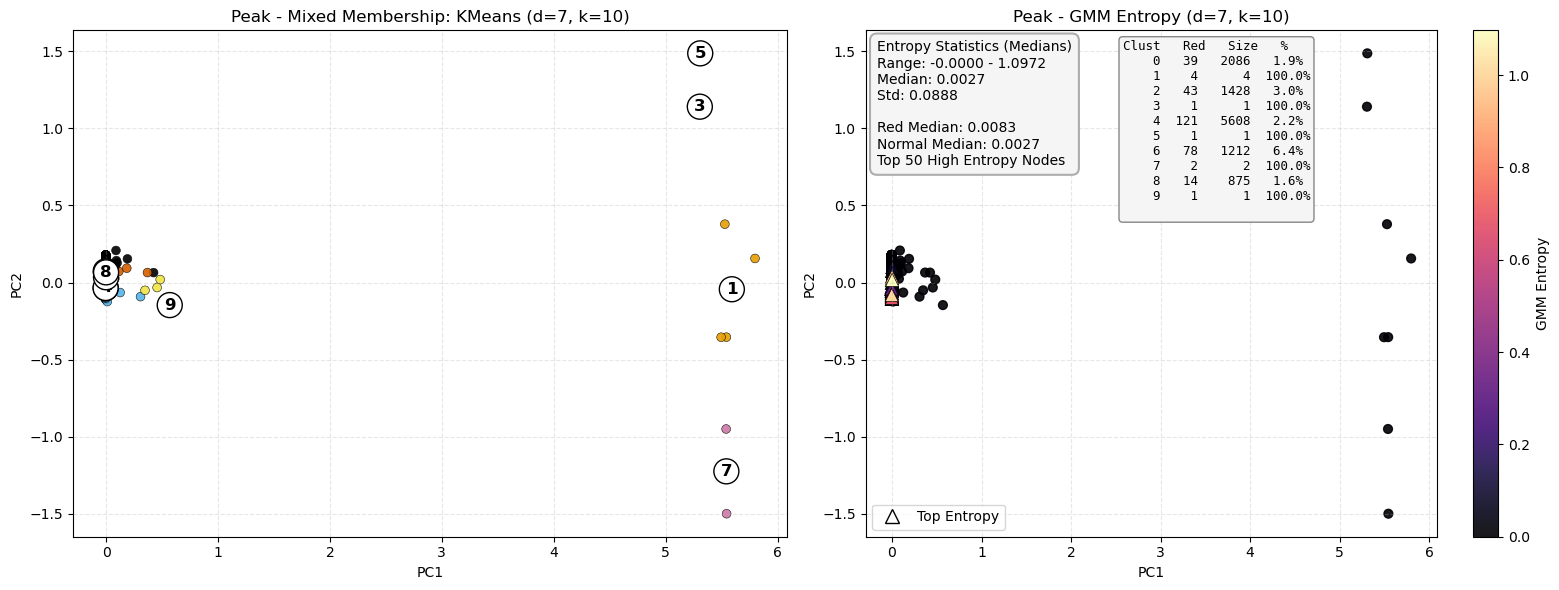


Red Team Distribution by Cluster:


,Cluster,Red Team Count,Cluster Size,Red %
0,0,39,2086,1.9%
1,1,4,4,100.0%
2,2,43,1428,3.0%
3,3,1,1,100.0%
4,4,121,5608,2.2%
5,5,1,1,100.0%
6,6,78,1212,6.4%
7,7,2,2,100.0%
8,8,14,875,1.6%
9,9,1,1,100.0%



LATE - Mixed Membership (d=7, k=10)
KMeans Silhouette Score for k=10: 0.402
GMM Silhouette Score for k=10: 0.305
GMM AIC: -472315.0
GMM BIC: -469698.5


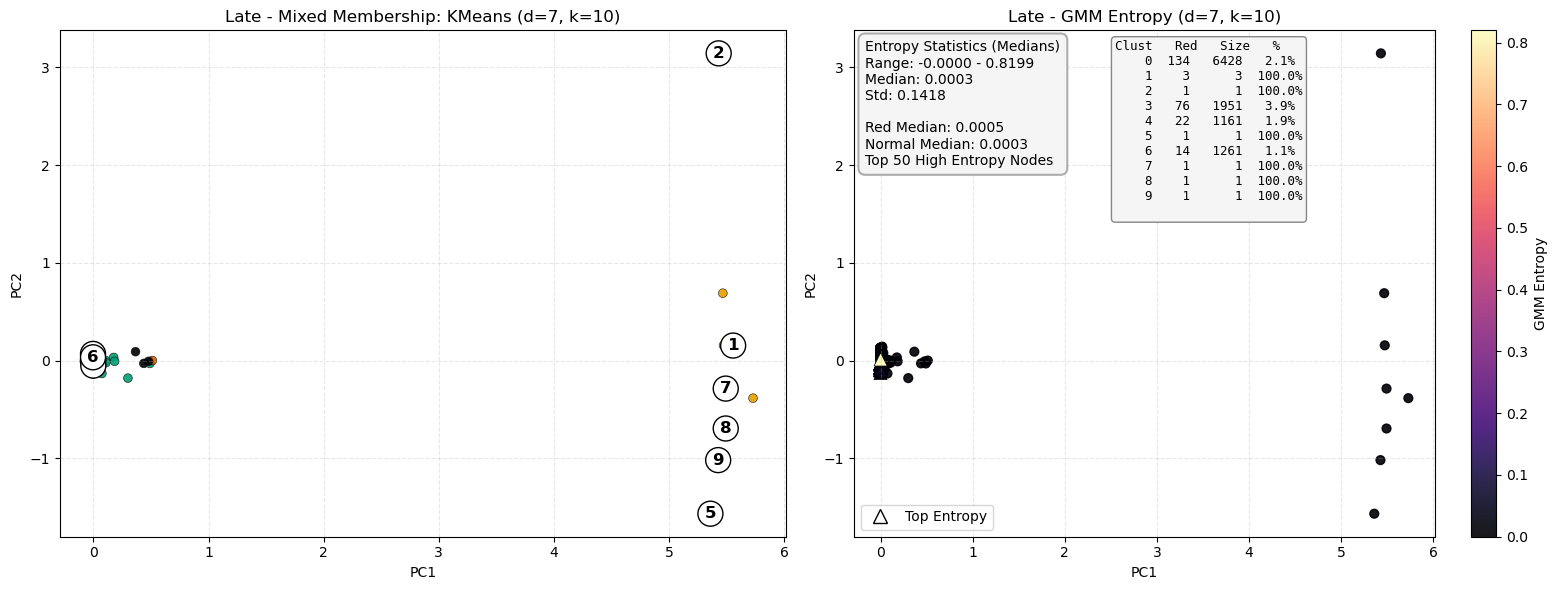


Red Team Distribution by Cluster:


,Cluster,Red Team Count,Cluster Size,Red %
0,0,134,6428,2.1%
1,1,3,3,100.0%
2,2,1,1,100.0%
3,3,76,1951,3.9%
4,4,22,1161,1.9%
5,5,1,1,100.0%
6,6,14,1261,1.1%
7,7,1,1,100.0%
8,8,1,1,100.0%
9,9,1,1,100.0%



COMPARATIVE SUMMARY ACROSS CONFIGURATIONS (MEDIANS)


,Period,Configuration,d,k,KMeans Silhouette,GMM Silhouette,GMM AIC,Red Median Entropy,Normal Median Entropy,Red/Normal Median
0,Early,Binary Classification,3,2,0.985,0.866,-177726.8,0.0000,0.0000,1.47
1,Peak,Binary Classification,3,2,0.986,0.876,-199023.7,0.0000,0.0000,2.67
2,Late,Binary Classification,3,2,0.987,0.891,-193653.3,0.0000,0.0000,1.51
3,Early,Mixed Membership,7,10,0.321,0.157,-457665.7,0.0005,0.0003,1.78
4,Peak,Mixed Membership,7,10,0.385,0.255,-514585.4,0.0083,0.0027,3.13
5,Late,Mixed Membership,7,10,0.402,0.305,-472315.0,0.0005,0.0003,1.99



MIN/MAX ENTROPY SUMMARY BY GROUP


,Period,d,k,Red Min Entropy,Red Max Entropy,Normal Min Entropy,Normal Max Entropy,Red Mean Entropy,Normal Mean Entropy,Red/Normal Mean Ratio
0,Early,3,2,-0.0000,0.6655,-0.0000,0.6926,0.0080,0.0006,12.74
1,Peak,3,2,-0.0000,0.4106,-0.0000,0.6931,0.0024,0.0006,3.89
2,Late,3,2,-0.0000,0.6766,-0.0000,0.6785,0.0054,0.0004,14.62
3,Early,7,10,-0.0000,0.5919,-0.0000,0.6922,0.0145,0.0079,1.83
4,Peak,7,10,-0.0000,1.0972,-0.0000,1.0605,0.0823,0.0257,3.21
5,Late,7,10,-0.0000,0.8199,-0.0000,0.6957,0.0430,0.0446,0.96


In [16]:
"""
Clustering analysis with medians in inset plots and summary tables.
- Replaces mean with median in inset entropy stats.
- Final comparative summary uses medians (and median ratio).
- Adds a second summary table with min/max entropy by red vs. normal.
"""

def analyse_period_clustering(
    embeddings_by_dimension: dict,
    node_lists: dict,
    red_computers: set,
    period_name: str,
    config_name: str,
    d: int,
    k: int,
    topk: int = 50,
):
    """
    Analyse clustering for one period with specific (d, k).

    Why certain choices:
    - Medians are more robust to outliers for entropy comparison.
    - AIC/BIC computed once to avoid repeated expensive calls.
    """

    print(f"\n{'='*60}")
    print(f"{period_name.upper()} - {config_name} (d={d}, k={k})")
    print(f"{'='*60}")

    # Data
    X_svd = embeddings_by_dimension[period_name][d]
    nodes = node_lists[period_name]

    # PCA 2D
    pca = PCA(n_components=2, svd_solver='full', random_state=42)
    X_2d = pca.fit_transform(X_svd)

    # KMeans
    kmeans_svd = KMeans(n_clusters=k, random_state=42).fit(X_svd)
    kmeans_labels_svd = kmeans_svd.labels_
    sil_score_kmeans = silhouette_score(X_svd, kmeans_labels_svd)
    kmeans_centres_2d = pca.transform(kmeans_svd.cluster_centers_)
    print(f"KMeans Silhouette Score for k={k}: {sil_score_kmeans:.3f}")

    # GMM
    gmm_svd = GaussianMixture(
        n_components=k,
        covariance_type="full",
        reg_covar=1e-6,
        n_init=10,
        max_iter=1000,
        init_params="kmeans",
        random_state=42,
    ).fit(X_svd)
    gmm_labels_svd = gmm_svd.predict(X_svd)
    sil_score_gmm = silhouette_score(X_svd, gmm_labels_svd)
    gmm_aic = gmm_svd.aic(X_svd)
    gmm_bic = gmm_svd.bic(X_svd)
    print(f"GMM Silhouette Score for k={k}: {sil_score_gmm:.3f}")
    print(f"GMM AIC: {gmm_aic:.1f}")
    print(f"GMM BIC: {gmm_bic:.1f}")

    # Entropy
    gmm_probs = gmm_svd.predict_proba(X_svd)
    entropy_scores = -np.sum(gmm_probs * np.log(gmm_probs + 1e-12), axis=1)
    top_entropy_idx = np.argsort(entropy_scores)[-topk:]

    # Red mask
    red_mask = np.array([node in red_computers for node in nodes])

    # Cluster summary
    cluster_analysis = []
    for cluster_id in range(k):
        cluster_mask = kmeans_labels_svd == cluster_id
        cluster_nodes = np.array(nodes)[cluster_mask]
        red_in_cluster = int(sum(1 for node in cluster_nodes if node in red_computers))
        total_in_cluster = int(len(cluster_nodes))
        pct = f"{100 * red_in_cluster / total_in_cluster:.1f}%" if total_in_cluster > 0 else "0.0%"
        cluster_analysis.append({
            "Cluster": cluster_id,
            "Red Team Count": red_in_cluster,
            "Cluster Size": total_in_cluster,
            "Red %": pct,
        })

    # Plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: KMeans
    OI = ["#000000","#E69F00","#56B4E9","#009E73","#F0E442","#0072B2","#D55E00","#CC79A7"]
    axes[0].scatter(
        X_2d[:, 0], X_2d[:, 1],
        c=kmeans_labels_svd,
        cmap=ListedColormap((OI * ((k // len(OI)) + 1))[:k]),
        s=40, alpha=0.9, edgecolor='black', linewidth=0.4,
    )
    for i, (x, y) in enumerate(kmeans_centres_2d):
        axes[0].text(
            x, y, str(i), fontsize=12, weight='bold', ha='center', va='center',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle'),
        )
    axes[0].set_title(f"{period_name.title()} - {config_name}: KMeans (d={d}, k={k})", fontsize=12)
    axes[0].set_xlabel("PC1")
    axes[0].set_ylabel("PC2")
    axes[0].grid(True, linestyle='--', alpha=0.3)

    # Plot 2: GMM entropy
    scatter2 = axes[1].scatter(
        X_2d[:, 0], X_2d[:, 1],
        c=entropy_scores, cmap="magma", s=40, alpha=0.9,
    )
    axes[1].scatter(
        X_2d[top_entropy_idx, 0], X_2d[top_entropy_idx, 1],
        c=entropy_scores[top_entropy_idx], cmap="magma",
        marker='^', s=90, edgecolors='black', linewidths=0.5,
        label='Top Entropy',
    )

    # Entropy stats (Medians)
    red_entropy = entropy_scores[red_mask] if red_mask.any() else np.array([np.nan])
    normal_entropy = entropy_scores[~red_mask] if (~red_mask).any() else np.array([np.nan])

    median_all = np.nanmedian(entropy_scores)
    median_red = np.nanmedian(red_entropy)
    median_normal = np.nanmedian(normal_entropy)

    entropy_stats_text = (
        f"Entropy Statistics (Medians)\n"
        f"Range: {np.nanmin(entropy_scores):.4f} - {np.nanmax(entropy_scores):.4f}\n"
        f"Median: {median_all:.4f}\n"
        f"Std: {np.nanstd(entropy_scores):.4f}\n\n"
        f"Red Median: {median_red:.4f}\n"
        f"Normal Median: {median_normal:.4f}\n"
        f"Top {topk} High Entropy Nodes"
    )

    axes[1].text(
        0.02, 0.98, entropy_stats_text, transform=axes[1].transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='whitesmoke', edgecolor='darkgray', linewidth=1.5, alpha=0.95),
    )

    # Cluster summary box
    cluster_summary_text = "Clust   Red   Size   %\n"
    for row in cluster_analysis:
        cluster_summary_text += f"{row['Cluster']:>5}  {row['Red Team Count']:>3}  {row['Cluster Size']:>5}  {row['Red %']:>5}\n"

    axes[1].text(
        0.45, 0.98, cluster_summary_text,
        transform=axes[1].transAxes,
        fontsize=9, family='monospace', verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='whitesmoke', edgecolor='gray', alpha=0.95),
    )

    # Legend/colorbar
    hollow_triangle = mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=10, markerfacecolor='none')
    cbar = fig.colorbar(scatter2, ax=axes[1])
    cbar.set_label("GMM Entropy")
    axes[1].set_title(f"{period_name.title()} - GMM Entropy (d={d}, k={k})", fontsize=12)
    axes[1].set_xlabel("PC1")
    axes[1].set_ylabel("PC2")
    axes[1].legend(handles=[hollow_triangle], labels=['Top Entropy'], fontsize=10, loc='lower left')
    axes[1].grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    fig.savefig(f"Fig_{period_name}_{config_name.replace(' ', '_')}_d{d}_k{k}.pdf", format='pdf', bbox_inches='tight', facecolor='white')
    plt.show()

    # Cluster table print
    summary_df = pd.DataFrame(cluster_analysis)
    print(f"\nRed Team Distribution by Cluster:")
    display(summary_df)

    return {
        'period': period_name,
        'config': config_name,
        'd': d,
        'k': k,
        'kmeans_silhouette': sil_score_kmeans,
        'gmm_silhouette': sil_score_gmm,
        'gmm_aic': gmm_aic,
        'gmm_bic': gmm_bic,
        'entropy_scores': entropy_scores,
        'kmeans_labels': kmeans_labels_svd,
        'gmm_labels': gmm_labels_svd,
        'red_mask': red_mask,
        'cluster_summary': summary_df,
    }


# --- Run both configurations for all periods ---
all_results = {}

# Configuration 1: Binary Classification (d=3, k=2)
for period in ["early", "peak", "late"]:
    if period in embeddings_by_dimension:
        result = analyse_period_clustering(
            embeddings_by_dimension, node_lists, red_computers,
            period_name=period,
            config_name="Binary Classification",
            d=3, k=2, topk=50,
        )
        all_results[f"{period}_binary"] = result

# Configuration 2: Mixed Membership (d=7, k=10)
for period in ["early", "peak", "late"]:
    if period in embeddings_by_dimension:
        result = analyse_period_clustering(
            embeddings_by_dimension, node_lists, red_computers,
            period_name=period,
            config_name="Mixed Membership",
            d=7, k=10, topk=50,
        )
        all_results[f"{period}_mixed"] = result

# --- Comparative summaries ---
print(f"\n{'='*80}")
print("COMPARATIVE SUMMARY ACROSS CONFIGURATIONS (MEDIANS)")
print(f"{'='*80}")

summary_data = []
summary_minmax = []

for key, result in all_results.items():
    ent = result['entropy_scores']
    mask = result['red_mask']

    red_vals = ent[mask] if mask.any() else np.array([np.nan])
    norm_vals = ent[~mask] if (~mask).any() else np.array([np.nan])

    red_median = float(np.nanmedian(red_vals))
    norm_median = float(np.nanmedian(norm_vals))
    ratio = red_median / norm_median if np.isfinite(red_median) and np.isfinite(norm_median) and norm_median > 0 else np.nan

    red_mean = np.nanmean(red_vals)
    norm_mean = np.nanmean(norm_vals)
    mean_ratio = red_mean / norm_mean if np.isfinite(red_mean) and np.isfinite(norm_mean) and norm_mean > 0 else np.nan
    
    summary_data.append({
        'Period': result['period'].title(),
        'Configuration': result['config'],
        'd': result['d'],
        'k': result['k'],
        'KMeans Silhouette': f"{result['kmeans_silhouette']:.3f}",
        'GMM Silhouette': f"{result['gmm_silhouette']:.3f}",
        'GMM AIC': f"{result['gmm_aic']:.1f}",
        'Red Median Entropy': f"{red_median:.4f}" if np.isfinite(red_median) else "NA",
        'Normal Median Entropy': f"{norm_median:.4f}" if np.isfinite(norm_median) else "NA",
        'Red/Normal Median': f"{ratio:.2f}" if np.isfinite(ratio) else "NA",
    })

    summary_minmax.append({
        'Period': result['period'].title(),
#        'Configuration': result['config'],
        'd': result['d'],
        'k': result['k'],
        'Red Min Entropy': f"{np.nanmin(red_vals):.4f}" if np.isfinite(np.nanmin(red_vals)) else "NA",
        'Red Max Entropy': f"{np.nanmax(red_vals):.4f}" if np.isfinite(np.nanmax(red_vals)) else "NA",
        'Normal Min Entropy': f"{np.nanmin(norm_vals):.4f}" if np.isfinite(np.nanmin(norm_vals)) else "NA",
        'Normal Max Entropy': f"{np.nanmax(norm_vals):.4f}" if np.isfinite(np.nanmax(norm_vals)) else "NA",
        'Red Mean Entropy': f"{np.nanmean(red_vals):.4f}" if np.isfinite(np.nanmean(red_vals)) else "NA",
        'Normal Mean Entropy': f"{np.nanmean(norm_vals):.4f}" if np.isfinite(np.nanmean(norm_vals)) else "NA",
        'Red/Normal Mean Ratio': f"{mean_ratio:.2f}" if np.isfinite(mean_ratio) else "NA",
    })

final_summary = pd.DataFrame(summary_data)
minmax_summary = pd.DataFrame(summary_minmax)

display(final_summary)
print("\nMIN/MAX ENTROPY SUMMARY BY GROUP")
display(minmax_summary)

### Step 9: Anomaly Detection Evaluation

Evaluate anomaly scoring on SVD embeddings using three methods, with red team computers as ground truth.

---

#### Inputs

- `X_svd` for a chosen period and dimension `d`.  
- `red_mask` derived from the period’s node list and the set of red team computers.  
- Cluster count `k` and a configuration label.

---

#### Methods and scores

1. **KMeans distance**
   - Fit KMeans with `k` clusters on `X_svd`.  
   - Score per node = distance to the nearest cluster centre.  
   - Larger distance indicates greater anomaly.

2. **GMM negative log‑likelihood**
   - Fit a Gaussian Mixture Model with `k` components on `X_svd`.  
   - Score per node = negative log‑likelihood from the fitted model.  
   - Larger value indicates poorer fit and greater anomaly.

3. **GMM entropy**
   - Compute posterior membership probabilities per node from the fitted GMM.  
   - Entropy $ H_i = -\sum_j p_{ij}\log p_{ij} $.  
   - Larger value indicates greater uncertainty and potential anomaly.

All three scores are treated so that **larger** means **more anomalous**.

---

#### Metrics reported

- **Precision@K** and **Recall@K** for $K \in \{10, 50, 100\}$:  
  - Rank nodes by score (descending).  
  - Precision@K = fraction of red nodes in the top \(K\).  
  - Recall@K = fraction of all red nodes recovered within the top \(K\).

- **Top 5% thresholding**  
  - Threshold at the 95th percentile of scores.  
  - Report Precision@95%ile and Recall@95%ile on the selected set.

- **ROC AUC**  
  - Area under the ROC curve for the full ranked list.
 
- **Entropy summary** per configuration: mean, median, minimum, maximum of GMM entropy scores.

Results are displayed in a fixed‑order table for each method:  
`Precision@10`, `Recall@10`, `Precision@50`, `Recall@50`, `Precision@100`, `Recall@100`, `Precision@95%ile`, `Recall@95%ile`, `ROC AUC`.

---

#### Execution

- Two configurations per period:  
  - **Binary Classification:** \( d = 3, k = 2 \).  
  - **Mixed Membership:** \( d = 7, k = 10 \).  
- For each configuration and period (Early, Peak, Late):  
  - Fit KMeans and GMM on `X_svd`.  
  - Compute KMeans distance, GMM negative log‑likelihood, and GMM entropy.  
  - Print the metric table.  

A final summary identifies, per period and configuration, the **best‑performing method by ROC AUC**.

---

#### Outputs

- Per‑period metric tables for KMeans distance, GMM negative log‑likelihood, and GMM entropy.  
- A concise summary of the best method by ROC AUC for each configuration and period.

---

In [17]:
def evaluate_anomaly_detection(embeddings_by_dimension, node_lists, red_computers, 
                              period, d, k, config_name):
    """Evaluate anomaly detection with standard metrics + entropy summary"""
    
    print(f"\n=== {period.upper()} - {config_name} (d={d}, k={k}) ===")
    
    # Get data
    X_svd = embeddings_by_dimension[period][d]
    nodes = node_lists[period]
    
    # Red team mask
    red_mask = np.array([node in red_computers for node in nodes], dtype=bool)
    total_red = int(red_mask.sum())
    
    # Fit models
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_svd)
    gmm = GaussianMixture(n_components=k, covariance_type="full",
                          reg_covar=1e-6, n_init=10, max_iter=1000,
                          init_params="kmeans", random_state=42).fit(X_svd)
    
    # Scores
    kmeans_distances = pairwise_distances(X_svd, kmeans.cluster_centers_).min(axis=1)
    gmm_scores = -gmm.score_samples(X_svd)
    probs = np.clip(gmm.predict_proba(X_svd), 1e-12, 1.0)
    entropy_scores = -np.sum(probs * np.log(probs), axis=1)
    entropy_scores = np.clip(entropy_scores, 0.0, np.log(k)) # keep in [0, log k]
    
    # Entropy summary
    entropy_summary = {
        "mean": float(np.mean(entropy_scores)),
        "median": float(np.median(entropy_scores)),
        "min": float(np.min(entropy_scores)),
        "max": float(np.max(entropy_scores)),
    }
    print("\nEntropy score summary:")
    for k_, v_ in entropy_summary.items():
        print(f"  {k_:<6}: {v_:.4f}")

    # Precompute AIC/BIC once and print (avoid recompute)
    gmm_aic = gmm.aic(X_svd)
    gmm_bic = gmm.bic(X_svd)
    print(f"GMM AIC: {gmm_aic:.1f}")
    print(f"GMM BIC: {gmm_bic:.1f}")
    
    # Evaluate anomaly detection metrics as before
    results = {}
    for method_name, scores in [("KMeans", kmeans_distances), 
                                ("GMM", gmm_scores), 
                                ("Entropy", entropy_scores)]:
        scores = np.asarray(scores)
        sorted_idx = np.argsort(scores, kind="stable")[::-1]     # high = more anomalous
        result = {}

        # Print max theoretical entropy before results loop
        print(f"\nEntropy max theoretical = {np.log(k):.4f}\n")

        # Precision/Recall@K
        for k_eval in [10, 50, 100]:
            if k_eval <= len(scores):
                top_k_red = int(red_mask[sorted_idx[:k_eval]].sum())
                result[f'Precision@{k_eval}'] = top_k_red / k_eval
                result[f'Recall@{k_eval}'] = (top_k_red / total_red) if total_red > 0 else 0.0
            else:
                result[f'Precision@{k_eval}'] = 0.0
                result[f'Recall@{k_eval}'] = 0.0
        
        # 95th percentile (top 5% by rank, exact count)
        n_95 = len(scores)
        k_top = int(np.ceil(0.05 * n_95))  # number of nodes to keep
        order_95 = np.argsort(scores, kind="stable")[::-1]  # higher scores = more anomalous
        sel = np.zeros(n_95, dtype=bool)
        sel[order_95[:k_top]] = True
        result['Precision@95%ile'] = float(red_mask[sel].mean()) if sel.sum() > 0 else 0.0
        result['Recall@95%ile'] = (int(red_mask[sel].sum()) / total_red) if total_red > 0 else 0.0
        
        # ROC AUC
        try:
            result['ROC AUC'] = float(roc_auc_score(red_mask, scores))
        except ValueError:
            result['ROC AUC'] = np.nan
        
        results[method_name] = result
    
    results_df = pd.DataFrame(results).T[
        ['Precision@10', 'Recall@10',
         'Precision@50', 'Recall@50',
         'Precision@100', 'Recall@100',
         'Precision@95%ile', 'Recall@95%ile',
         'ROC AUC']
    ]
    
    display(results_df.round(6))
    return results_df, entropy_summary

# Run all evaluations
print("="*100)
print("=== COMPREHENSIVE PERFORMANCE COMPARISON (ALL METHODS) ===")
print("="*100)

# Store all results
all_period_results = []

# Binary Classification (d=3, k=2)
for period in ["early", "peak", "late"]:
    if period in embeddings_by_dimension and 3 in embeddings_by_dimension[period]:
        df, ent = evaluate_anomaly_detection(
            embeddings_by_dimension, node_lists, red_computers,
            period, d=3, k=2, config_name="Binary Classification"
        )
        all_period_results.append((period, "Binary_d3_k2", df, ent))

# Mixed Membership (d=7, k=10)
for period in ["early", "peak", "late"]:
    if period in embeddings_by_dimension and 7 in embeddings_by_dimension[period]:
        df, ent = evaluate_anomaly_detection(
            embeddings_by_dimension, node_lists, red_computers,
            period, d=7, k=10, config_name="Mixed Membership"
        )
        all_period_results.append((period, "Mixed_d7_k10", df, ent))

# Summary of best performers
print(f"\n{'='*100}")
print("SUMMARY: BEST PERFORMING METHODS")
print(f"{'='*100}")

for period, config, df, ent in all_period_results:
    print(f"\n{period.upper()} - {config}:")
    best_roc = df['ROC AUC'].max()
    best_method = df['ROC AUC'].idxmax()
    print(f"  Best ROC AUC: {best_method} ({best_roc:.6f})")

=== COMPREHENSIVE PERFORMANCE COMPARISON (ALL METHODS) ===

=== EARLY - Binary Classification (d=3, k=2) ===

Entropy score summary:
  mean  : 0.0008
  median: 0.0000
  min   : 0.0000
  max   : 0.6926
GMM AIC: -177726.8
GMM BIC: -177589.7

Entropy max theoretical = 0.6931


Entropy max theoretical = 0.6931


Entropy max theoretical = 0.6931



,Precision@10,Recall@10,Precision@50,Recall@50,Precision@100,Recall@100,Precision@95%ile,Recall@95%ile,ROC AUC
KMeans,1.0,0.038911,0.52,0.101167,0.42,0.163424,0.114851,0.225681,0.641456
GMM,1.0,0.038911,0.72,0.140078,0.64,0.249027,0.190099,0.373541,0.758379
Entropy,0.2,0.007782,0.28,0.054475,0.23,0.089494,0.079208,0.155642,0.556060



=== PEAK - Binary Classification (d=3, k=2) ===

Entropy score summary:
  mean  : 0.0007
  median: 0.0000
  min   : 0.0000
  max   : 0.6931
GMM AIC: -199023.7
GMM BIC: -198884.6

Entropy max theoretical = 0.6931


Entropy max theoretical = 0.6931


Entropy max theoretical = 0.6931



,Precision@10,Recall@10,Precision@50,Recall@50,Precision@100,Recall@100,Precision@95%ile,Recall@95%ile,ROC AUC
KMeans,1.0,0.032895,0.56,0.092105,0.31,0.101974,0.153298,0.282895,0.657929
GMM,1.0,0.032895,0.78,0.128289,0.65,0.213816,0.178253,0.328947,0.826593
Entropy,0.1,0.003289,0.36,0.059211,0.28,0.092105,0.073084,0.134868,0.633310



=== LATE - Binary Classification (d=3, k=2) ===

Entropy score summary:
  mean  : 0.0005
  median: 0.0000
  min   : 0.0000
  max   : 0.6785
GMM AIC: -193653.3
GMM BIC: -193514.8

Entropy max theoretical = 0.6931


Entropy max theoretical = 0.6931


Entropy max theoretical = 0.6931



,Precision@10,Recall@10,Precision@50,Recall@50,Precision@100,Recall@100,Precision@95%ile,Recall@95%ile,ROC AUC
KMeans,1.0,0.039370,0.44,0.086614,0.22,0.086614,0.127542,0.271654,0.631770
GMM,1.0,0.039370,0.82,0.161417,0.62,0.244094,0.203327,0.433071,0.755086
Entropy,0.2,0.007874,0.38,0.074803,0.24,0.094488,0.090573,0.192913,0.563184



=== EARLY - Mixed Membership (d=7, k=10) ===

Entropy score summary:
  mean  : 0.0081
  median: 0.0003
  min   : 0.0000
  max   : 0.6922
GMM AIC: -457665.7
GMM BIC: -455073.6

Entropy max theoretical = 2.3026


Entropy max theoretical = 2.3026


Entropy max theoretical = 2.3026



,Precision@10,Recall@10,Precision@50,Recall@50,Precision@100,Recall@100,Precision@95%ile,Recall@95%ile,ROC AUC
KMeans,1.0,0.038911,0.30,0.058366,0.16,0.062257,0.047525,0.093385,0.498997
GMM,1.0,0.038911,0.68,0.132296,0.57,0.221790,0.152475,0.299611,0.637259
Entropy,0.0,0.000000,0.04,0.007782,0.08,0.031128,0.041584,0.081712,0.492189



=== PEAK - Mixed Membership (d=7, k=10) ===

Entropy score summary:
  mean  : 0.0272
  median: 0.0027
  min   : 0.0000
  max   : 1.0972
GMM AIC: -514585.4
GMM BIC: -511955.6

Entropy max theoretical = 2.3026


Entropy max theoretical = 2.3026


Entropy max theoretical = 2.3026



,Precision@10,Recall@10,Precision@50,Recall@50,Precision@100,Recall@100,Precision@95%ile,Recall@95%ile,ROC AUC
KMeans,1.0,0.032895,0.34,0.055921,0.19,0.062500,0.055258,0.101974,0.582517
GMM,0.8,0.026316,0.70,0.115132,0.66,0.217105,0.172906,0.319079,0.782691
Entropy,0.4,0.013158,0.14,0.023026,0.13,0.042763,0.083779,0.154605,0.547992



=== LATE - Mixed Membership (d=7, k=10) ===

Entropy score summary:
  mean  : 0.0446
  median: 0.0003
  min   : 0.0000
  max   : 0.8199
GMM AIC: -472315.0
GMM BIC: -469698.5

Entropy max theoretical = 2.3026


Entropy max theoretical = 2.3026


Entropy max theoretical = 2.3026



,Precision@10,Recall@10,Precision@50,Recall@50,Precision@100,Recall@100,Precision@95%ile,Recall@95%ile,ROC AUC
KMeans,0.9,0.035433,0.22,0.043307,0.11,0.043307,0.031423,0.066929,0.502517
GMM,0.7,0.027559,0.62,0.122047,0.59,0.232283,0.157116,0.334646,0.680229
Entropy,0.1,0.003937,0.02,0.003937,0.03,0.011811,0.018484,0.039370,0.519756



SUMMARY: BEST PERFORMING METHODS

EARLY - Binary_d3_k2:
  Best ROC AUC: GMM (0.758379)

PEAK - Binary_d3_k2:
  Best ROC AUC: GMM (0.826593)

LATE - Binary_d3_k2:
  Best ROC AUC: GMM (0.755086)

EARLY - Mixed_d7_k10:
  Best ROC AUC: GMM (0.637259)

PEAK - Mixed_d7_k10:
  Best ROC AUC: GMM (0.782691)

LATE - Mixed_d7_k10:
  Best ROC AUC: GMM (0.680229)
